## Bibliotecas

In [2]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sqlalchemy as sa 
from sqlalchemy import create_engine
import sqlite3
import cx_Oracle as cx 
import warnings
import numpy as np 
from IPython.core.display import HTML
import seaborn as sns
from scipy.stats import norm
import statistics as estat
import sys
from datetime import date, timedelta, datetime
import pandas.tseries.offsets as ts 

In [3]:
# Formatar para duas casas decimais
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

### Acesso ao Banco

In [4]:
# Create table in database sqlite

#Create database SQlite
db = sa.create_engine ('sqlite:///base_tcc.sqlite', echo=False)

In [5]:
conn = db.connect()

## Seleção dos Dados

In [212]:
query_cubo= """
SELECT
pdi.numped, 
pdi.data as DATA_PEDIDO,
pc.dtfat,
pc.dtentrega,
pdi.codprod,
pdt.codepto,
pdt.codsec,
pcl.bloqueio,
(pdi.vlcustofin * pdi.qt) AS CUSTO_TRANSACAO, 
(pdi.pvenda * pdi.qt) AS PRECO_TRANSACAO,
(pdi.pvenda * pdi.qt) as TOTAL_VENDA,
(pdi.pvenda * pdi.qt) - (pdi.vlcustofin * pdi.qt) as LUCRO_BRUTO,
pdi.qt,
pdi.codcli,
pdi.codusur,
pcu.codsupervisor,
pcl.codcidade,
pc.codfilial, 
pc.tipovenda,
pc.codcob,
pc.codplpag,
pc.condvenda, 
SUM((pdi.qt / pdt.qtunitcx)) AS CAIXAS
FROM pcpedi pdi INNER JOIN pcpedc pc     ON ( pdi.numped = pc.numped)
                INNER JOIN pcclient pcl  ON ( pdi.codcli = pcl.codcli)
                INNER JOIN pcusuari pcu  ON ( pdi.codusur = pcu.codusur) 
                INNER JOIN pcsuperv psp  ON ( pcu.codsupervisor = psp.codsupervisor)
                INNER JOIN pcplpag ppg   ON ( pc.codplpag = ppg.codplpag)
                 LEFT JOIN pccidade pcd  ON ( pcl.codcidade = pcd.codcidade )
                 LEFT JOIN pcprodut pdt  ON ( pdi.codprod = pdt.codprod)
                 LEFT JOIN pcdepto dpt   ON ( pdt.codepto = dpt.codepto)
                 LEFT JOIN pcsecao psc   ON ( pdt.codsec = psc.codsec)
WHERE pdi.data between '2022-02-01' AND '2022-04-30'
AND pcu.codsupervisor not in (1,137,140,135)
GROUP BY pdi.numped, 
pdi.data,
pc.dtfat,
pc.dtentrega,
pdi.codprod,
pdt.codepto,
pdt.codsec,
pcl.bloqueio,
pdi.codcli,
pdi.codusur,
pcu.codsupervisor,
pcl.codcidade,
pc.codfilial, 
pc.tipovenda,
pc.codcob,
pc.codplpag,
pc.condvenda
ORDER BY LUCRO_BRUTO DESC
"""
table_cubo = pd.DataFrame()
table_cubo = pd.read_sql_query (query_cubo, conn)
cubo = pd.DataFrame()
cubo = table_cubo.copy()
cubo

,NUMPED,DATA_PEDIDO,DTFAT,DTENTREGA,CODPROD,CODEPTO,CODSEC,BLOQUEIO,CUSTO_TRANSACAO,PRECO_TRANSACAO,TOTAL_VENDA,LUCRO_BRUTO,QT,CODCLI,CODUSUR,CODSUPERVISOR,CODCIDADE,CODFILIAL,TIPOVENDA,CODCOB,CODPLPAG,CONDVENDA,CAIXAS
0,2021000769,2022-04-25 00:00:00.000000,2022-04-30 00:00:00.000000,2022-05-04 00:00:00.000000,4706,157,337,N,6722.33,8550.00,8550.00,1827.67,1500.00,6632,2021,138,16327.00,1,VP,BK,9,1,100.00
1,335004743,2022-03-18 00:00:00.000000,2022-03-18 00:00:00.000000,2022-03-22 00:00:00.000000,1268,101,142,N,14281.79,15878.98,15878.98,1597.19,3000.00,2409,335,136,16390.00,1,VP,BK,4,1,200.00
2,2021000708,2022-03-21 00:00:00.000000,2022-03-26 00:00:00.000000,2022-03-31 00:00:00.000000,4706,157,337,N,6077.12,7650.00,7650.00,1572.88,1500.00,14873,2021,138,16327.00,1,VP,BK,10,1,100.00
3,2021000665,2022-02-24 00:00:00.000000,2022-02-26 00:00:00.000000,2022-03-02 00:00:00.000000,4706,157,337,N,6083.10,7650.00,7650.00,1566.90,1500.00,6632,2021,138,16327.00,1,VP,BK,10,1,100.00
4,306005149,2022-02-11 00:00:00.000000,2022-02-11 00:00:00.000000,2022-02-14 00:00:00.000000,4706,157,337,N,8800.10,10350.00,10350.00,1549.90,2250.00,8233,306,138,16418.00,1,VP,BK,5,1,150.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42234,352005324,2022-03-23 00:00:00.000000,2022-03-26 00:00:00.000000,2022-03-28 00:00:00.000000,8161,102,132,N,1216.72,1112.50,1112.50,-104.22,1250.00,18414,306,138,16418.00,1,VV,DH,1,1,25.00
42235,306005255,2022-03-25 00:00:00.000000,2022-03-25 00:00:00.000000,2022-03-28 00:00:00.000000,8161,102,132,N,997.83,890.00,890.00,-107.83,1000.00,14571,306,138,16418.00,1,VP,BK,10,1,20.00
42236,335004761,2022-04-11 00:00:00.000000,2022-04-13 00:00:00.000000,2022-04-20 00:00:00.000000,23801,155,328,N,709.83,585.19,585.19,-124.64,45.00,1602,335,136,16385.00,1,VP,BK,10,1,3.00
42237,352005094,2022-02-04 00:00:00.000000,2022-02-08 00:00:00.000000,2022-02-09 00:00:00.000000,8169,102,132,N,3037.58,2852.50,2852.50,-185.08,3500.00,18414,352,138,16418.00,1,VV,DH,1,1,70.00


## Data Preparation

In [7]:
# Alter types
cubo['DATA_PEDIDO'] = pd.to_datetime(cubo['DATA_PEDIDO'])
cubo['DTFAT'] = pd.to_datetime(cubo['DTFAT'])
cubo['DTENTREGA'] = pd.to_datetime(cubo['DTENTREGA'])
cubo['NUMPED'] = cubo['NUMPED'].astype('object')
cubo['CODPROD'] = cubo['CODPROD'].astype('category')
cubo['CODEPTO'] = cubo['CODEPTO'].astype('category')
cubo['CODSEC'] = cubo['CODSEC'].astype('category')
cubo['CODCLI'] = cubo['CODCLI'].astype('object')
cubo['CODUSUR'] = cubo['CODUSUR'].astype('category')
cubo['CODSUPERVISOR'] = cubo['CODSUPERVISOR'].astype('category')
cubo['CODCIDADE'] = cubo['CODCIDADE'].astype('category')
cubo['CODPLPAG'] = cubo['CODPLPAG'].astype('category')
cubo['CONDVENDA'] = cubo['CONDVENDA'].astype('category') 

#Filtro de supervisões descontinuadas
cubo = cubo[(cubo['CODSUPERVISOR'] == 61) |(cubo['CODSUPERVISOR'] == 136) |(cubo['CODSUPERVISOR'] == 138)]

# Alteração de objetos para numérico
churn_numeric = {'S':1,'N':0}
cubo.BLOQUEIO.replace(churn_numeric, inplace=True)

#Bonificações agrupados por cliente
cubo_cliente = pd.DataFrame(cubo.groupby(['CODCLI']).agg({'NUMPED':'nunique','CODEPTO':'nunique', 'CODSEC':'nunique', 'CUSTO_TRANSACAO':'sum','TOTAL_VENDA':'sum','CAIXAS':'sum','LUCRO_BRUTO':'sum'}))
cubo_bnft = pd.DataFrame(cubo[cubo['CODCOB'].str.contains('BNF|BNFT')])
cubo_nobnft = cubo[~cubo['CODCOB'].str.contains('BNF|BNFT')]
cubo_nobnft['BONIFICACAO'] = cubo_bnft['TOTAL_VENDA']

#Funcão de Subtração
def subtracao(a,b):
    return a - b 

#Divisao de Cliente da Classe natural de churn e não churn
cubo_nobnft['LUCRO_LIQUIDO']  = cubo_nobnft.apply(lambda x: subtracao(x['LUCRO_BRUTO'], x['BONIFICACAO']), axis=1)
cubo_bnft_cliente = pd.DataFrame(cubo_bnft.groupby(['CODCLI']).agg({'NUMPED':'nunique','CUSTO_TRANSACAO':'sum','TOTAL_VENDA':'sum','CAIXAS':'sum'}).sort_values('TOTAL_VENDA', ascending=False))
cubo_nobnft_cliente = pd.DataFrame(cubo_nobnft.groupby(by=['CODCLI']).agg({'NUMPED':'nunique','CUSTO_TRANSACAO':'sum','TOTAL_VENDA':'sum','CAIXAS':'sum','BONIFICACAO':'sum','LUCRO_BRUTO':'sum'}).sort_values('TOTAL_VENDA', ascending=False)).reset_index()

#Features criadas para maior segmentação de características
VENDA_MABEL = cubo[cubo['CODEPTO'].isin([101,103,123,156])]
VENDA_GSA = cubo[cubo['CODEPTO'].isin([102,137,138])]
VENDA_RANCHEIRO = cubo[cubo['CODEPTO'].isin([157,159])]
VENDA_OUTROS = cubo[np.logical_not(cubo['CODEPTO'].isin([101,103,123,156,102,137,138,157,159]))]

#Definição do conjunto principal
cubo_cliente = cubo_nobnft_cliente.copy()

#tratamento de dimensões de data
cubo_cliente['DATA_PEDIDO'] = cubo['DATA_PEDIDO'].dt.strftime('%Y-%m-%d')
cubo_cliente['DATA_REF'] = cubo['DATA_PEDIDO'].max()

#criação de feature de lucro com dedução de bonificações
cubo_cliente['LUCRO_LIQUIDO']  = cubo_cliente.apply(lambda x: subtracao(x['LUCRO_BRUTO'], x['BONIFICACAO']), axis=1).reset_index(drop=True)

#tranformação de tipo de dados
cubo_cliente['CHURN_STATUS']  = cubo['BLOQUEIO'].astype('int')
cubo_cliente['CODCIDADE']     = cubo['CODCIDADE'].astype('int')
cubo_cliente['CODUSUR']       = cubo['CODUSUR'].astype('category')
cubo_cliente['CODSUPERVISOR'] = cubo['CODSUPERVISOR'].astype('category')
cubo_cliente['CODFILIAL']     = cubo['CODFILIAL']
cubo_cliente['VENDA_M'] = VENDA_MABEL['TOTAL_VENDA']
cubo_cliente['VENDA_G'] = VENDA_GSA['TOTAL_VENDA']
cubo_cliente['VENDA_R'] = VENDA_RANCHEIRO['TOTAL_VENDA']
cubo_cliente['VENDA_OUTROS'] = VENDA_OUTROS['TOTAL_VENDA']

#criação de métricas ( Tentativa de suprir a falta de métricas do negócio)
cubo_cliente['MARGEM'] = (cubo_cliente['TOTAL_VENDA'] - (cubo_cliente['CUSTO_TRANSACAO'] + cubo_cliente['BONIFICACAO']))/ cubo_cliente['TOTAL_VENDA']
cubo_cliente['ROI'] = (cubo_cliente['TOTAL_VENDA'] - (cubo_cliente['CUSTO_TRANSACAO'] + cubo_cliente['BONIFICACAO'])) / (cubo_cliente['CUSTO_TRANSACAO'] + cubo_cliente['BONIFICACAO'])

#Ordenação de Data frame pelo retorno do investimento
cubo_cliente = cubo_cliente.sort_values(['ROI'], ascending=False).reset_index(drop=True)

#limpeza de dados
cubo_cliente = cubo_cliente.replace(np.nan,0).reset_index(drop=True)

cubo_cliente

C:\Users\Andre\AppData\Local\Temp\ipykernel_1736\964174098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cubo_nobnft['BONIFICACAO'] = cubo_bnft['TOTAL_VENDA']
C:\Users\Andre\AppData\Local\Temp\ipykernel_1736\964174098.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cubo_nobnft['LUCRO_LIQUIDO']  = cubo_nobnft.apply(lambda x: subtracao(x['LUCRO_BRUTO'], x['BONIFICACAO']), axis=1)


,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI
0,16888,2,539.76,824.90,10.00,0.00,285.14,2022-04-20,2022-04-29,285.14,0,16426,321,136,1,0.00,695.40,0.00,0.00,0.35,0.53
1,16891,1,175.40,262.34,4.00,0.00,86.94,2022-04-18,2022-04-29,86.94,0,16420,321,136,1,0.00,0.00,398.32,0.00,0.33,0.50
2,7888,1,166.77,247.05,3.00,0.00,80.28,2022-03-29,2022-04-29,80.28,1,16418,402,61,1,0.00,442.50,0.00,0.00,0.32,0.48
3,3966,1,117.65,173.24,3.00,0.00,55.59,2022-03-25,2022-04-29,55.59,0,16404,385,138,1,0.00,0.00,386.72,0.00,0.32,0.47
4,8106,2,162.64,237.00,2.00,0.00,74.36,2022-04-05,2022-04-29,74.36,0,16418,306,138,1,0.00,540.00,0.00,0.00,0.31,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,16805,2,611.95,630.14,70.00,0.00,18.19,2022-02-26,2022-04-29,18.19,1,16423,321,136,1,0.00,0.00,329.32,0.00,0.03,0.03
1271,2876,1,145.15,148.50,3.00,0.00,3.35,2022-02-26,2022-04-29,3.35,0,16423,321,136,1,0.00,0.00,360.49,0.00,0.02,0.02
1272,18268,1,2695.40,2700.00,60.00,0.00,4.60,2022-04-08,2022-04-29,4.60,0,16385,335,136,1,0.00,0.00,796.64,0.00,0.00,0.00
1273,18414,7,29055.00,28645.00,610.00,0.00,-410.00,2022-04-18,2022-04-29,-410.00,0,16339,321,136,1,0.00,0.00,4409.83,0.00,-0.01,-0.01


In [8]:
cubo_cliente.dropna(inplace=True)
cubo_cliente.isna().sum()

CODCLI             0
NUMPED             0
CUSTO_TRANSACAO    0
TOTAL_VENDA        0
CAIXAS             0
BONIFICACAO        0
LUCRO_BRUTO        0
DATA_PEDIDO        0
DATA_REF           0
LUCRO_LIQUIDO      0
CHURN_STATUS       0
CODCIDADE          0
CODUSUR            0
CODSUPERVISOR      0
CODFILIAL          0
VENDA_M            0
VENDA_G            0
VENDA_R            0
VENDA_OUTROS       0
MARGEM             0
ROI                0
dtype: int64

In [9]:
teste_prob = cubo_cliente.copy()

## Criação de Features 

In [10]:
teste_prob['DATA_PEDIDO'] = pd.to_datetime(teste_prob['DATA_PEDIDO'])
#teste_prob['PROB_CHURN'] = 0.0
td = timedelta(days=60)
percent_churn = []
def prob_churn (data):
    for indice, linha in teste_prob.iterrows():
        percent_churn.append(1.00 if ((linha['DATA_REF'] - td) < linha['DATA_REF']) else (linha['DATA_REF'] - linha['DATA_PEDIDO']) / 60 )
    data['PROB_CHURN'] = percent_churn
prob_churn(teste_prob)
teste_prob['CHURN_STATUS'] = np.where(teste_prob['PROB_CHURN'] > 0.9, 1, 0)
#teste_prob.sort_values(by='CHURN_STATUS', ascending=True)                       

In [11]:
cubo_cliente['PROB_CHURN'] = 0.0
cubo_cliente['PROB_CHURN'] = cubo_cliente['PROB_CHURN'].astype('float')
cubo_cliente['DATA_PEDIDO'] = pd.to_datetime(cubo_cliente['DATA_PEDIDO'])

percent_churn = []

td = timedelta(60)
def prob_churn (data):
    for indice, linha in cubo_cliente.iterrows():
        percent_churn.append(1.00 if linha['DATA_REF'] - td  > linha['DATA_PEDIDO'] else ((linha['DATA_REF'] - linha['DATA_PEDIDO']).days / 60) )
    data['PROB_CHURN'] = percent_churn
    
prob_churn(cubo_cliente)
cubo_cliente['CHURN_STATUS'] = np.where(cubo_cliente['PROB_CHURN']>0.95,1,0)
cubo_cliente

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN
0,16888,2,539.76,824.90,10.00,0.00,285.14,2022-04-20,2022-04-29,285.14,0,16426,321,136,1,0.00,695.40,0.00,0.00,0.35,0.53,0.15
1,16891,1,175.40,262.34,4.00,0.00,86.94,2022-04-18,2022-04-29,86.94,0,16420,321,136,1,0.00,0.00,398.32,0.00,0.33,0.50,0.18
2,7888,1,166.77,247.05,3.00,0.00,80.28,2022-03-29,2022-04-29,80.28,0,16418,402,61,1,0.00,442.50,0.00,0.00,0.32,0.48,0.52
3,3966,1,117.65,173.24,3.00,0.00,55.59,2022-03-25,2022-04-29,55.59,0,16404,385,138,1,0.00,0.00,386.72,0.00,0.32,0.47,0.58
4,8106,2,162.64,237.00,2.00,0.00,74.36,2022-04-05,2022-04-29,74.36,0,16418,306,138,1,0.00,540.00,0.00,0.00,0.31,0.46,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,16805,2,611.95,630.14,70.00,0.00,18.19,2022-02-26,2022-04-29,18.19,1,16423,321,136,1,0.00,0.00,329.32,0.00,0.03,0.03,1.00
1271,2876,1,145.15,148.50,3.00,0.00,3.35,2022-02-26,2022-04-29,3.35,1,16423,321,136,1,0.00,0.00,360.49,0.00,0.02,0.02,1.00
1272,18268,1,2695.40,2700.00,60.00,0.00,4.60,2022-04-08,2022-04-29,4.60,0,16385,335,136,1,0.00,0.00,796.64,0.00,0.00,0.00,0.35
1273,18414,7,29055.00,28645.00,610.00,0.00,-410.00,2022-04-18,2022-04-29,-410.00,0,16339,321,136,1,0.00,0.00,4409.83,0.00,-0.01,-0.01,0.18


In [12]:
def top_m (target):
    if (target > 6800.00):
        return 'high'
    elif(target > 4030.00):
        return 'standard'
    elif(target > 2000.00):
        return 'low'
    else:
        return 'high_low'

cubo_cliente['TOP_M'] = cubo_cliente['VENDA_M'].apply(top_m)

def top_g (target):
    if (target > 2450.00):
        return 'high'
    elif(target > 2000.00):
        return 'standard'
    elif(target > 1590.00):
        return 'low'
    else:
        return 'high_low'

cubo_cliente['TOP_G'] = cubo_cliente['VENDA_G'].apply(top_g)

def top_r (target):
    if (target > 5500.00):
        return 'high'
    elif(target > 2000.00):
        return 'standard'
    elif(target > 1590.00):
        return 'low'
    else:
        return 'high_low'

cubo_cliente['TOP_R'] = cubo_cliente['VENDA_R'].apply(top_r)

In [13]:
cubo_cliente['NUMPED'] = cubo_cliente['CODFILIAL'].astype('int')
cubo_cliente['CODCIDADE'] = cubo_cliente['CODCIDADE'].astype('category')
cubo_cliente['CODCLI'] = cubo_cliente['CODCLI'].astype('int64')
cubo_cliente['CODFILIAL'] = cubo_cliente['CODFILIAL'].astype('category')
cubo_cliente['CHURN_STATUS'] = cubo_cliente['CHURN_STATUS'].astype('int64')
cubo_cliente['TOP_G'] = cubo_cliente['TOP_G'].astype('category')
cubo_cliente['TOP_M'] = cubo_cliente['TOP_M'].astype('category')
cubo_cliente['TOP_R'] = cubo_cliente['TOP_R'].astype('category')

In [14]:
cubo_cliente

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
0,16888,1,539.76,824.90,10.00,0.00,285.14,2022-04-20,2022-04-29,285.14,0,16426,321,136,1,0.00,695.40,0.00,0.00,0.35,0.53,0.15,high_low,high_low,high_low
1,16891,1,175.40,262.34,4.00,0.00,86.94,2022-04-18,2022-04-29,86.94,0,16420,321,136,1,0.00,0.00,398.32,0.00,0.33,0.50,0.18,high_low,high_low,high_low
2,7888,1,166.77,247.05,3.00,0.00,80.28,2022-03-29,2022-04-29,80.28,0,16418,402,61,1,0.00,442.50,0.00,0.00,0.32,0.48,0.52,high_low,high_low,high_low
3,3966,1,117.65,173.24,3.00,0.00,55.59,2022-03-25,2022-04-29,55.59,0,16404,385,138,1,0.00,0.00,386.72,0.00,0.32,0.47,0.58,high_low,high_low,high_low
4,8106,1,162.64,237.00,2.00,0.00,74.36,2022-04-05,2022-04-29,74.36,0,16418,306,138,1,0.00,540.00,0.00,0.00,0.31,0.46,0.40,high_low,high_low,high_low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,16805,1,611.95,630.14,70.00,0.00,18.19,2022-02-26,2022-04-29,18.19,1,16423,321,136,1,0.00,0.00,329.32,0.00,0.03,0.03,1.00,high_low,high_low,high_low
1271,2876,1,145.15,148.50,3.00,0.00,3.35,2022-02-26,2022-04-29,3.35,1,16423,321,136,1,0.00,0.00,360.49,0.00,0.02,0.02,1.00,high_low,high_low,high_low
1272,18268,1,2695.40,2700.00,60.00,0.00,4.60,2022-04-08,2022-04-29,4.60,0,16385,335,136,1,0.00,0.00,796.64,0.00,0.00,0.00,0.35,high_low,high_low,high_low
1273,18414,1,29055.00,28645.00,610.00,0.00,-410.00,2022-04-18,2022-04-29,-410.00,0,16339,321,136,1,0.00,0.00,4409.83,0.00,-0.01,-0.01,0.18,high_low,high_low,standard


In [15]:
cubo_cliente[cubo_cliente['CHURN_STATUS'] == 1]

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
8,4181,1,76.96,111.00,1.00,0.00,34.04,2022-02-23,2022-04-29,34.04,1,16441,321,136,1,0.00,0.00,371.94,0.00,0.31,0.44,1.00,high_low,high_low,high_low
17,15038,1,265.81,377.29,3.30,0.00,111.48,2022-02-09,2022-04-29,111.48,1,16321,380,136,1,0.00,388.92,0.00,0.00,0.30,0.42,1.00,high_low,high_low,high_low
21,17988,1,92.50,130.76,2.08,0.00,38.27,2022-02-09,2022-04-29,38.27,1,16358,300,138,1,448.02,0.00,0.00,0.00,0.29,0.41,1.00,high_low,high_low,high_low
22,4049,1,141.81,200.08,3.27,0.00,58.27,2022-02-22,2022-04-29,58.27,1,16418,352,138,1,0.00,0.00,0.00,580.00,0.29,0.41,1.00,high_low,high_low,high_low
25,14368,1,578.85,810.00,8.00,0.00,231.15,2022-02-01,2022-04-29,231.15,1,16441,321,136,1,0.00,477.00,0.00,0.00,0.29,0.40,1.00,high_low,high_low,high_low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,16130,1,315.54,337.40,5.50,0.00,21.86,2022-02-03,2022-04-29,21.86,1,16418,328,138,1,0.00,0.00,294.00,0.00,0.06,0.07,1.00,high_low,high_low,high_low
1268,17395,1,156.24,162.00,3.00,0.00,5.76,2022-02-09,2022-04-29,5.76,1,16418,328,138,1,449.25,0.00,0.00,0.00,0.04,0.04,1.00,high_low,high_low,high_low
1269,2515,1,1269.40,1307.16,12.00,0.00,37.75,2022-02-05,2022-04-29,37.75,1,16403,306,138,1,0.00,0.00,433.50,0.00,0.03,0.03,1.00,high_low,high_low,high_low
1270,16805,1,611.95,630.14,70.00,0.00,18.19,2022-02-26,2022-04-29,18.19,1,16423,321,136,1,0.00,0.00,329.32,0.00,0.03,0.03,1.00,high_low,high_low,high_low


In [16]:
cubo_cliente[cubo_cliente['CHURN_STATUS'] == 0]

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
0,16888,1,539.76,824.90,10.00,0.00,285.14,2022-04-20,2022-04-29,285.14,0,16426,321,136,1,0.00,695.40,0.00,0.00,0.35,0.53,0.15,high_low,high_low,high_low
1,16891,1,175.40,262.34,4.00,0.00,86.94,2022-04-18,2022-04-29,86.94,0,16420,321,136,1,0.00,0.00,398.32,0.00,0.33,0.50,0.18,high_low,high_low,high_low
2,7888,1,166.77,247.05,3.00,0.00,80.28,2022-03-29,2022-04-29,80.28,0,16418,402,61,1,0.00,442.50,0.00,0.00,0.32,0.48,0.52,high_low,high_low,high_low
3,3966,1,117.65,173.24,3.00,0.00,55.59,2022-03-25,2022-04-29,55.59,0,16404,385,138,1,0.00,0.00,386.72,0.00,0.32,0.47,0.58,high_low,high_low,high_low
4,8106,1,162.64,237.00,2.00,0.00,74.36,2022-04-05,2022-04-29,74.36,0,16418,306,138,1,0.00,540.00,0.00,0.00,0.31,0.46,0.40,high_low,high_low,high_low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,12251,1,250.13,264.87,5.00,0.00,14.74,2022-04-12,2022-04-29,14.74,0,16415,321,136,1,0.00,0.00,398.32,0.00,0.06,0.06,0.28,high_low,high_low,high_low
1267,18640,1,493.24,514.35,9.33,0.00,21.11,2022-03-24,2022-04-29,21.11,0,16308,300,138,1,0.00,0.00,464.06,0.00,0.04,0.04,0.60,high_low,high_low,high_low
1272,18268,1,2695.40,2700.00,60.00,0.00,4.60,2022-04-08,2022-04-29,4.60,0,16385,335,136,1,0.00,0.00,796.64,0.00,0.00,0.00,0.35,high_low,high_low,high_low
1273,18414,1,29055.00,28645.00,610.00,0.00,-410.00,2022-04-18,2022-04-29,-410.00,0,16339,321,136,1,0.00,0.00,4409.83,0.00,-0.01,-0.01,0.18,high_low,high_low,standard


## ROI Analysis

In [17]:
# Mediana Geral do ROI
cubo_cliente['ROI'].median()

### Os dados gerais s

#Media Geral do ROI
cubo_cliente['ROI'].mean()

# Mediana do ROI maior que 0.18
cubo_cliente['ROI'][cubo_cliente['ROI'] > 0.18].median()

#Mediana do ROI menor que 0.18
cubo_cliente['ROI'][cubo_cliente['ROI'] <= 0.18].median()

# Media do ROI maior que 0.18
cubo_cliente['ROI'][cubo_cliente['ROI'] > 0.18].mean()

#Media do ROI menor que 0.18
cubo_cliente['ROI'][cubo_cliente['ROI'] <= 0.18].mean()

0.1349348573263484

## Agrupamentos Churn Status

In [18]:
cubo_cliente[['CODSUPERVISOR','CHURN_STATUS']].groupby(['CODSUPERVISOR']).mean().reset_index()

,CODSUPERVISOR,CHURN_STATUS
0,61,0.17
1,136,0.31
2,138,0.36


In [19]:
agrupamento_usur = cubo_cliente[['CODUSUR','CHURN_STATUS']].groupby(['CODUSUR']).mean().sort_values(by='CHURN_STATUS', ascending= False).reset_index()
agrupamento_usur = agrupamento_usur.dropna()
agrupamento_usur

,CODUSUR,CHURN_STATUS
0,328,0.89
1,380,0.68
2,352,0.52
3,362,0.49
4,300,0.38
5,321,0.35
6,335,0.25
7,306,0.24
8,2022,0.19
9,2021,0.18


## Análise Univariada

In [20]:
cubo_cliente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CODCLI           1275 non-null   int64         
 1   NUMPED           1275 non-null   int32         
 2   CUSTO_TRANSACAO  1275 non-null   float64       
 3   TOTAL_VENDA      1275 non-null   float64       
 4   CAIXAS           1275 non-null   float64       
 5   BONIFICACAO      1275 non-null   float64       
 6   LUCRO_BRUTO      1275 non-null   float64       
 7   DATA_PEDIDO      1275 non-null   datetime64[ns]
 8   DATA_REF         1275 non-null   datetime64[ns]
 9   LUCRO_LIQUIDO    1275 non-null   float64       
 10  CHURN_STATUS     1275 non-null   int64         
 11  CODCIDADE        1275 non-null   category      
 12  CODUSUR          1275 non-null   category      
 13  CODSUPERVISOR    1275 non-null   category      
 14  CODFILIAL        1275 non-null   categor

C:\Users\Andre\tcc\virtual\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Andre\tcc\virtual\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Andre\tcc\virtual\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\Andre\tcc\virtual\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keywo

<AxesSubplot:xlabel='PROB_CHURN', ylabel='Density'>

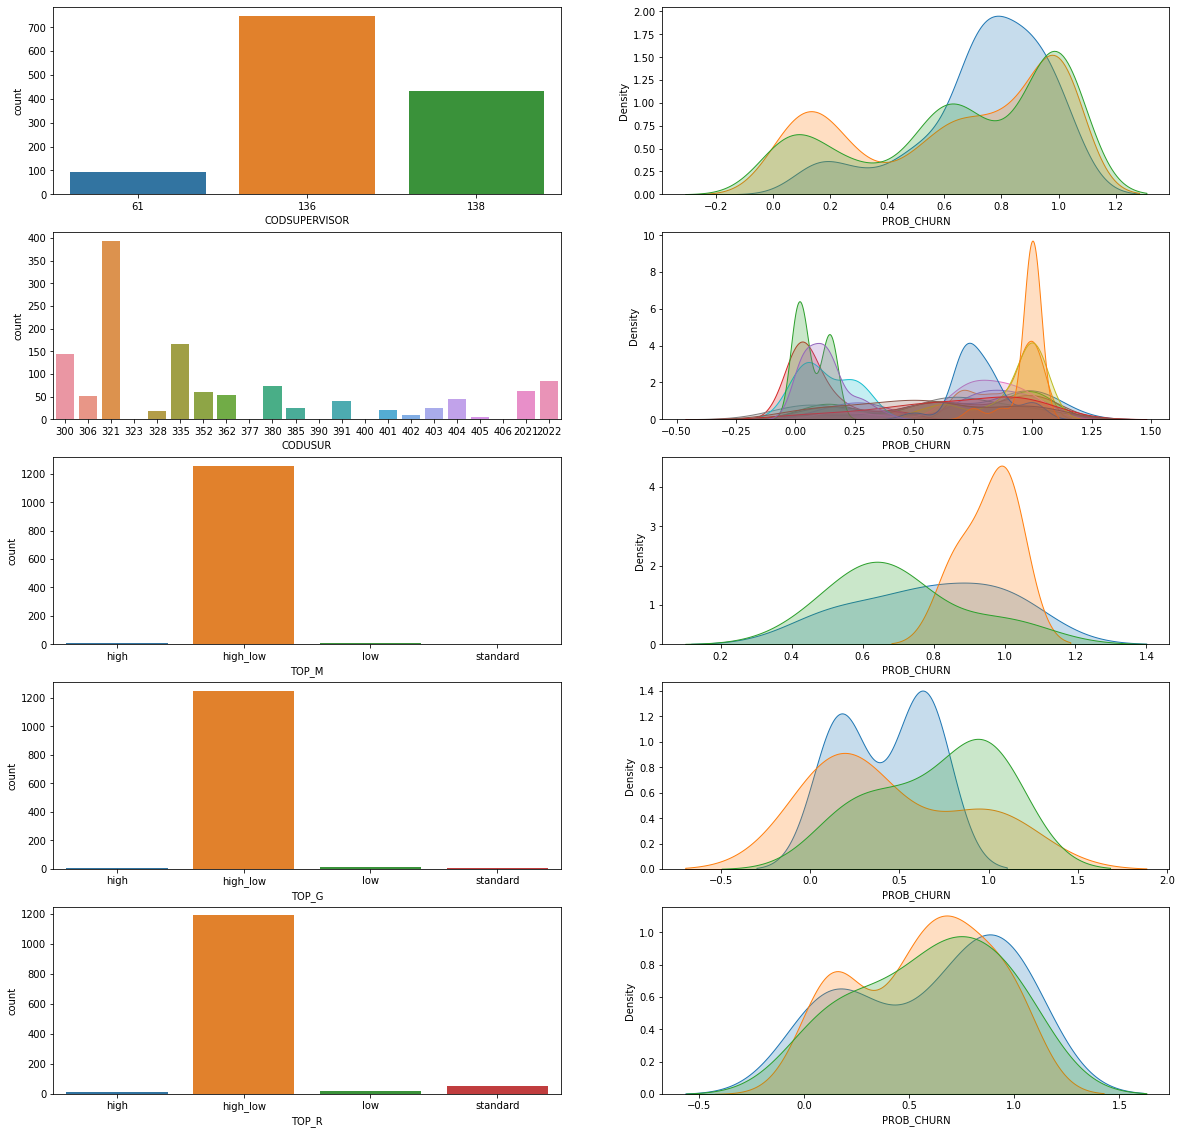

In [21]:
plt.figure(figsize = (20 , 20))
#CODSUPERVISOR 
plt.subplot(5, 2, 1)
sns.countplot(cubo_cliente['CODSUPERVISOR'])

plt.subplot(5, 2, 2)
sns.kdeplot( cubo_cliente[cubo_cliente['CODSUPERVISOR'] == 61]['PROB_CHURN'], label='61', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODSUPERVISOR'] == 136]['PROB_CHURN'], label='136', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODSUPERVISOR'] == 138]['PROB_CHURN'], label='138', shade=True)

#CODUSUR 

plt.subplot(5, 2, 3)
sns.countplot(cubo_cliente['CODUSUR'])

plt.subplot(5, 2, 4)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 362]['PROB_CHURN'], label='362', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 352]['PROB_CHURN'], label='352', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 321]['PROB_CHURN'], label='321', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 401]['PROB_CHURN'], label='401', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 335]['PROB_CHURN'], label='335', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 300]['PROB_CHURN'], label='300', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 2022]['PROB_CHURN'], label='2022', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 2021]['PROB_CHURN'], label='2021', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 380]['PROB_CHURN'], label='380', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 405]['PROB_CHURN'], label='405', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 382]['PROB_CHURN'], label='382', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 391]['PROB_CHURN'], label='391', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 328]['PROB_CHURN'], label='328', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 404]['PROB_CHURN'], label='404', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 385]['PROB_CHURN'], label='385', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 403]['PROB_CHURN'], label='403', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 306]['PROB_CHURN'], label='306', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 351]['PROB_CHURN'], label='351', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['CODUSUR'] == 402]['PROB_CHURN'], label='402', shade=True)

#TOP_M 
plt.subplot(5, 2, 5)
sns.countplot(cubo_cliente['TOP_M'])

plt.subplot(5, 2, 6)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_M'] == 'high low']['PROB_CHURN'], label='high low', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_M'] == 'low']['PROB_CHURN'], label='low', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_M'] == 'standard']['PROB_CHURN'], label='standard', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_M'] == 'high']['PROB_CHURN'], label='138', shade=True)

#TOP_G 
plt.subplot(5, 2, 7)
sns.countplot(cubo_cliente['TOP_G'])

plt.subplot(5, 2, 8)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_G'] == 'high low']['PROB_CHURN'], label='high low', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_G'] == 'low']['PROB_CHURN'], label='low', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_G'] == 'standard']['PROB_CHURN'], label='standard', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_G'] == 'high']['PROB_CHURN'], label='138', shade=True)

#TOP_R 
plt.subplot(5, 2, 9)
sns.countplot(cubo_cliente['TOP_R'])

plt.subplot(5, 2, 10)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_R'] == 'high low']['PROB_CHURN'], label='high low', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_R'] == 'low']['PROB_CHURN'], label='low', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_R'] == 'standard']['PROB_CHURN'], label='standard', shade=True)
sns.kdeplot( cubo_cliente[cubo_cliente['TOP_R'] == 'high']['PROB_CHURN'], label='138', shade=True)

In [39]:
def top_m (target):
    if (target > 5000):
        return 3
    elif(target > 3000):
        return 2
    elif(target > 1000.00):
        return 1
    else:
        return 0

cubo_cliente['TOP_M'] = cubo_cliente['VENDA_M'].apply(top_m)

def top_g (target):
    if (target > 2000.00):
        return 3
    elif(target > 1500.00):
        return 2
    elif(target > 500.00):
        return 1
    else:
        return 0

cubo_cliente['TOP_G'] = cubo_cliente['VENDA_G'].apply(top_g)

def top_r (target):
    if (target > 3000):
        return 3
    elif(target > 1000.00):
        return 2
    elif(target > 500.00):
        return 1
    else:
        return 0

cubo_cliente['TOP_R'] = cubo_cliente['VENDA_R'].apply(top_r)

## Análise Bivariada

In [40]:
#pearson
cubo_cliente.corr()

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,LUCRO_LIQUIDO,CHURN_STATUS,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
CODCLI,1.00,NaN,-0.09,-0.09,-0.08,NaN,-0.10,-0.10,0.06,0.01,-0.02,-0.11,-0.01,-0.05,-0.05,0.05,0.01,-0.04,-0.12
NUMPED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUSTO_TRANSACAO,-0.09,NaN,1.00,1.00,0.99,NaN,0.96,0.96,-0.03,0.33,-0.04,0.76,0.05,-0.10,-0.10,-0.01,0.23,0.00,0.59
TOTAL_VENDA,-0.09,NaN,1.00,1.00,0.99,NaN,0.97,0.97,-0.03,0.33,-0.04,0.75,0.05,-0.08,-0.08,-0.01,0.23,0.00,0.59
CAIXAS,-0.08,NaN,0.99,0.99,1.00,NaN,0.95,0.95,-0.03,0.32,-0.04,0.75,0.06,-0.11,-0.11,-0.01,0.22,0.00,0.58
BONIFICACAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LUCRO_BRUTO,-0.10,NaN,0.96,0.97,0.95,NaN,1.00,1.00,-0.04,0.35,-0.03,0.70,0.02,0.02,0.01,-0.01,0.24,0.01,0.56
LUCRO_LIQUIDO,-0.10,NaN,0.96,0.97,0.95,NaN,1.00,1.00,-0.04,0.35,-0.03,0.70,0.02,0.02,0.01,-0.01,0.24,0.01,0.56
CHURN_STATUS,0.06,NaN,-0.03,-0.03,-0.03,NaN,-0.04,-0.04,1.00,0.03,-0.05,-0.07,0.20,-0.06,-0.06,0.71,0.03,-0.06,-0.08
VENDA_M,0.01,NaN,0.33,0.33,0.32,NaN,0.35,0.35,0.03,1.00,-0.11,-0.08,-0.03,-0.01,-0.01,0.07,0.90,-0.08,-0.09


In [41]:
cubo_cliente.corr("spearman")

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,LUCRO_LIQUIDO,CHURN_STATUS,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
CODCLI,1.00,NaN,-0.17,-0.17,-0.15,NaN,-0.18,-0.18,0.06,0.00,0.01,-0.08,0.01,-0.03,-0.03,0.05,0.00,-0.04,-0.11
NUMPED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUSTO_TRANSACAO,-0.17,NaN,1.00,1.00,0.99,NaN,0.97,0.97,0.02,0.02,-0.03,0.37,-0.02,-0.11,-0.11,0.05,0.14,0.19,0.55
TOTAL_VENDA,-0.17,NaN,1.00,1.00,0.99,NaN,0.98,0.98,0.02,0.02,-0.03,0.37,-0.02,-0.08,-0.08,0.05,0.14,0.18,0.55
CAIXAS,-0.15,NaN,0.99,0.99,1.00,NaN,0.95,0.95,0.02,0.01,-0.03,0.37,-0.02,-0.13,-0.13,0.05,0.14,0.18,0.54
BONIFICACAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LUCRO_BRUTO,-0.18,NaN,0.97,0.98,0.95,NaN,1.00,1.00,0.01,0.03,-0.04,0.37,-0.02,0.08,0.08,0.04,0.14,0.18,0.54
LUCRO_LIQUIDO,-0.18,NaN,0.97,0.98,0.95,NaN,1.00,1.00,0.01,0.03,-0.04,0.37,-0.02,0.08,0.08,0.04,0.14,0.18,0.54
CHURN_STATUS,0.06,NaN,0.02,0.02,0.02,NaN,0.01,0.01,1.00,0.12,-0.07,-0.11,0.28,-0.05,-0.05,0.82,0.05,-0.07,-0.07
VENDA_M,0.00,NaN,0.02,0.02,0.01,NaN,0.03,0.03,0.12,1.00,-0.24,-0.24,-0.08,0.02,0.02,0.15,0.68,-0.16,-0.17


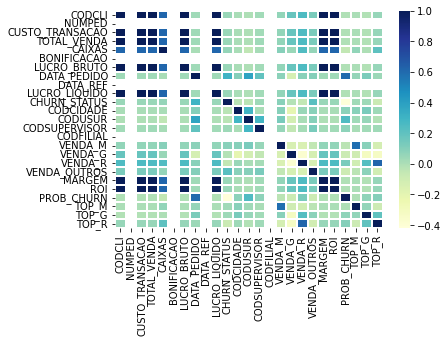

In [42]:
df_corr = cubo_cliente.apply(lambda x: pd.factorize(x)[0])
ax = sns.heatmap(df_corr.corr(), xticklabels=df_corr.columns, yticklabels=df_corr.columns, linewidths=.2, cmap="YlGnBu")

<AxesSubplot:>

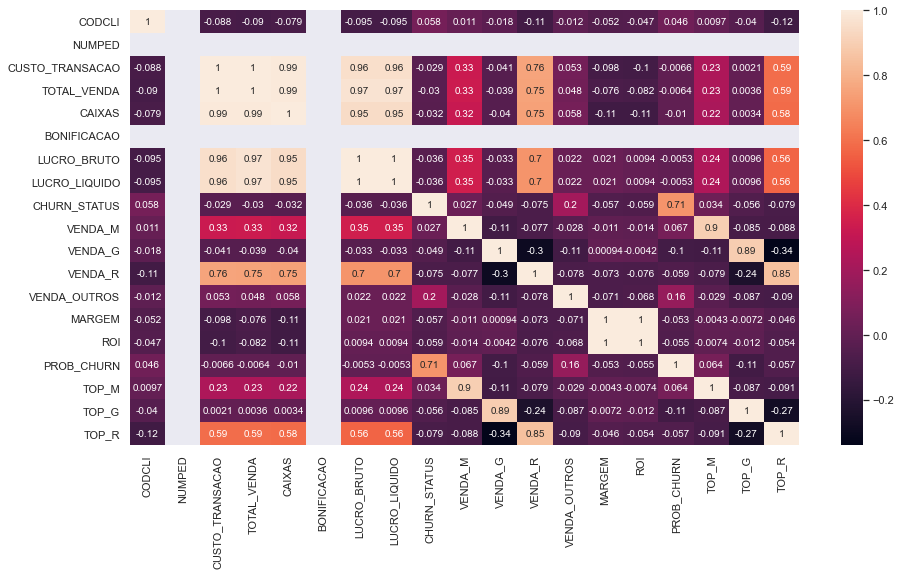

In [43]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(cubo_cliente.corr(), annot=True, annot_kws={'size':10})

## Taxa Geral de Churn

In [44]:
cubo_churn = cubo_cliente[cubo_cliente['CHURN_STATUS'] == 1]

cubo_nochurn = cubo_cliente[cubo_cliente['CHURN_STATUS'] == 0]

taxa_atual_churn =  len(cubo_churn) / (len(cubo_nochurn) + len(cubo_churn))
print("A taxa atual de Churn é:", taxa_atual_churn)

A taxa atual de Churn é: 0.3184313725490196


In [45]:
cubo_churn.sort_values(by='BONIFICACAO', ascending=False).reset_index(drop=True)

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
0,4181,1,76.96,111.00,1.00,0.00,34.04,2022-02-23,2022-04-29,34.04,1,16441,321,136,1,0.00,0.00,371.94,0.00,0.31,0.44,1.00,0,0,0
1,3938,1,965.28,1191.63,16.77,0.00,226.35,2022-02-11,2022-04-29,226.35,1,16314,380,136,1,0.00,0.00,0.00,621.10,0.19,0.23,1.00,0,0,0
2,15450,1,3009.86,3706.39,54.24,0.00,696.53,2022-02-25,2022-04-29,696.53,1,16409,300,138,1,0.00,972.30,0.00,0.00,0.19,0.23,1.00,0,1,0
3,2548,1,1627.93,2005.51,26.60,0.00,377.59,2022-02-10,2022-04-29,377.59,1,16321,380,136,1,0.00,516.08,0.00,0.00,0.19,0.23,1.00,0,1,0
4,7486,1,3381.82,4166.33,57.00,0.00,784.51,2022-02-26,2022-04-29,784.51,1,16423,321,136,1,0.00,0.00,860.60,0.00,0.19,0.23,1.00,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,4498,1,2563.48,3275.94,38.80,0.00,712.45,2022-02-24,2022-04-29,712.45,1,16418,352,138,1,0.00,0.00,584.10,0.00,0.22,0.28,1.00,0,0,1
402,13465,1,6854.52,8760.17,100.00,0.00,1905.65,2022-02-10,2022-04-29,1905.65,1,16321,380,136,1,3967.50,0.00,0.00,0.00,0.22,0.28,1.00,2,0,0
403,1856,1,2348.16,3001.03,38.36,0.00,652.87,2022-02-04,2022-04-29,652.87,1,16418,352,138,1,0.00,0.00,570.00,0.00,0.22,0.28,1.00,0,0,1
404,16927,1,3250.67,4156.58,45.00,0.00,905.91,2022-02-26,2022-04-29,905.91,1,16441,321,136,1,0.00,0.00,860.60,0.00,0.22,0.28,1.00,0,0,1


In [46]:
cubo_nochurn.sort_values(by='BONIFICACAO', ascending=False).reset_index(drop=True)

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
0,16888,1,539.76,824.90,10.00,0.00,285.14,2022-04-20,2022-04-29,285.14,0,16426,321,136,1,0.00,695.40,0.00,0.00,0.35,0.53,0.15,0,1,0
1,14803,1,715.14,882.94,11.50,0.00,167.81,2022-03-07,2022-04-29,167.81,0,16353,300,138,1,0.00,0.00,424.13,0.00,0.19,0.23,0.88,0,0,0
2,7776,1,2964.91,3668.03,57.67,0.00,703.12,2022-03-08,2022-04-29,703.12,0,16404,385,138,1,0.00,0.00,839.77,0.00,0.19,0.24,0.87,0,0,1
3,2327,1,2946.99,3644.79,44.50,0.00,697.80,2022-03-18,2022-04-29,697.80,0,16390,335,136,1,0.00,3178.40,0.00,0.00,0.19,0.24,0.70,0,3,0
4,2417,1,3142.84,3887.00,50.59,0.00,744.16,2022-03-18,2022-04-29,744.16,0,16390,335,136,1,1324.80,0.00,0.00,0.00,0.19,0.24,0.70,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,16863,1,762.46,978.52,13.75,0.00,216.06,2022-04-25,2022-04-29,216.06,0,16339,321,136,1,0.00,695.40,0.00,0.00,0.22,0.28,0.07,0,1,0
865,15191,1,2836.17,3639.84,41.00,0.00,803.66,2022-03-17,2022-04-29,803.66,0,16388,335,136,1,0.00,0.00,835.53,0.00,0.22,0.28,0.72,0,0,1
866,17303,1,480.35,616.32,7.75,0.00,135.97,2022-03-31,2022-04-29,135.97,0,16423,321,136,1,0.00,0.00,334.56,0.00,0.22,0.28,0.48,0,0,0
867,1719,1,6306.22,8090.60,100.92,0.00,1784.37,2022-04-20,2022-04-29,1784.37,0,16308,300,138,1,0.00,0.00,1775.65,0.00,0.22,0.28,0.15,0,0,2


In [47]:
cubo_cliente['BONIFICACAO'].sum()

0.0

In [48]:
#Total de Investimento BONUS feito para os clientes que deixaram de comprar
# Foram bonificados R$ 13.125,00 reais para 95 que entraram em churn
cubo_churn['BONIFICACAO'].sum()

0.0

In [49]:
cubo_churn['LUCRO_LIQUIDO'].sum()

222357.786672

In [50]:
#Media de bonificacao media para clientes com churn é maior que a média geral R$ 138,00 contra R$ 103,00
cubo_nochurn['BONIFICACAO'].sum()

0.0

In [51]:
cubo_nochurn['LUCRO_LIQUIDO'].sum() 

560051.569219

## Numerical Attributes

In [52]:
#Separando Numericos de Categoricos
num_attributes = cubo_cliente.select_dtypes(include=['int','float'])
cat_attributes = cubo_cliente.select_dtypes(exclude=['int','float','datetime64[ns]'])

### Central Tendency and Dispersion

In [53]:
d1 = pd.DataFrame( num_attributes.apply(np.std )).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis())) .T
                  
metrics = pd.concat([d2, d3, d4, d1, d2, d1, d5, d6]).T.reset_index()

In [54]:
metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,CODCLI,1297.00,18682.00,17385.00,6256.99,1297.00,6256.99,-0.20,-1.60
1,NUMPED,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
2,CUSTO_TRANSACAO,30.60,79413.93,79383.34,5226.42,30.60,5226.42,6.92,69.21
3,TOTAL_VENDA,40.82,98972.56,98931.74,6430.04,40.82,6430.04,7.06,72.97
4,CAIXAS,0.35,1441.25,1440.90,88.12,0.35,88.12,7.22,78.01
5,BONIFICACAO,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,LUCRO_BRUTO,-410.00,19558.62,19968.63,1247.73,-410.00,1247.73,7.79,88.78
7,LUCRO_LIQUIDO,-410.00,19558.62,19968.63,1247.73,-410.00,1247.73,7.79,88.78
8,CHURN_STATUS,0.00,1.00,1.00,0.47,0.00,0.47,0.78,-1.39
9,VENDA_M,0.00,15878.98,15878.98,792.72,0.00,792.72,11.96,184.60


In [55]:
cubo_cliente.describe()

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,LUCRO_LIQUIDO,CHURN_STATUS,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
count,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00,1275.00
mean,10618.29,1.00,2539.64,3153.29,43.01,0.00,613.65,613.65,0.32,131.21,291.41,459.81,52.35,0.20,0.26,0.65,0.05,0.28,0.40
std,6259.44,0.00,5228.47,6432.57,88.15,0.00,1248.22,1248.22,0.47,793.03,456.18,992.40,309.93,0.04,0.07,0.34,0.29,0.54,0.76
min,1297.00,1.00,30.60,40.82,0.35,0.00,-410.00,-410.00,0.00,0.00,0.00,0.00,0.00,-0.02,-0.02,0.00,0.00,0.00,0.00
25%,3972.50,1.00,425.90,528.98,7.78,0.00,106.79,106.79,0.00,0.00,0.00,0.00,0.00,0.18,0.22,0.30,0.00,0.00,0.00
50%,13475.00,1.00,1097.52,1367.43,19.00,0.00,263.33,263.33,0.00,0.00,0.00,0.00,0.00,0.21,0.26,0.72,0.00,0.00,0.00
75%,16480.00,1.00,2531.74,3163.81,43.92,0.00,654.23,654.23,1.00,0.00,489.64,524.99,0.00,0.23,0.30,1.00,0.00,0.00,1.00
max,18682.00,1.00,79413.93,98972.56,1441.25,0.00,19558.62,19558.62,1.00,15878.98,3540.00,10350.00,7182.00,0.35,0.53,1.00,3.00,3.00,3.00


## Explorer Plots

In [56]:
#histogramas = ['TOTAL_VENDA', 'LUCRO_LIQUIDO', 'PROB_CHURN']
#fig, ax = plt.subplots(3,1, figsize = (8,20))

#for i in range(3):
    #ax[i].boxplot(cubo_cliente[histogramas[i]])
    #ax[i].set_title(histogramas[i])
    
#plt.show()

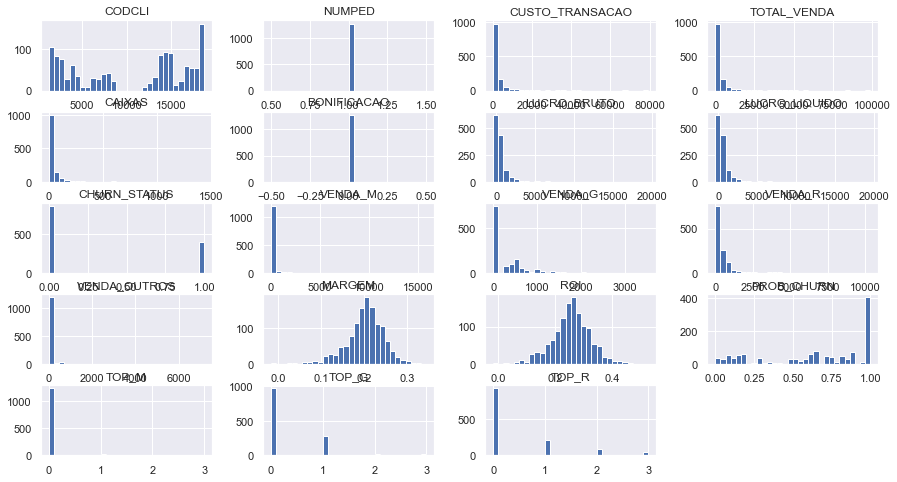

In [57]:
num_attributes.hist(bins=30);

In [58]:
# Cortando altas bonificações que nao estão dando lucro. O retorno de investimento para a maioria dos clientes que recebem bonificação acima de R$2.000 é negativo.
# Indicando o corte de bonificações desta magnitude ou aplicando a prática de limites ou negociações para clientes específicos.

In [59]:
cubo_bnft_danger_roi = pd.DataFrame()
cubo_bnft_danger_roi = cubo_cliente[cubo_cliente['ROI'] < 0.15].reset_index(drop=True)

In [60]:
cubo_bnft_danger_roi

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
0,8233,1,40231.32,46200.00,650.00,0.00,5968.68,2022-03-23,2022-04-29,5968.68,0,16339,321,136,1,0.00,0.00,7650.00,0.00,0.13,0.15,0.62,0,0,3
1,12534,1,798.85,916.04,14.40,0.00,117.19,2022-03-23,2022-04-29,117.19,0,16441,321,136,1,0.00,0.00,375.17,0.00,0.13,0.15,0.62,0,0,0
2,13630,1,292.99,335.84,5.42,0.00,42.85,2022-02-03,2022-04-29,42.85,1,16418,328,138,1,0.00,0.00,294.00,0.00,0.13,0.15,1.00,0,0,0
3,2898,1,2249.49,2577.55,30.97,0.00,328.05,2022-02-26,2022-04-29,328.05,1,16441,321,136,1,0.00,0.00,570.27,0.00,0.13,0.15,1.00,0,0,1
4,14586,1,6533.83,7482.70,133.00,0.00,948.87,2022-03-16,2022-04-29,948.87,0,16408,2022,61,1,0.00,0.00,1605.00,0.00,0.13,0.15,0.73,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,16805,1,611.95,630.14,70.00,0.00,18.19,2022-02-26,2022-04-29,18.19,1,16423,321,136,1,0.00,0.00,329.32,0.00,0.03,0.03,1.00,0,0,0
84,2876,1,145.15,148.50,3.00,0.00,3.35,2022-02-26,2022-04-29,3.35,1,16423,321,136,1,0.00,0.00,360.49,0.00,0.02,0.02,1.00,0,0,0
85,18268,1,2695.40,2700.00,60.00,0.00,4.60,2022-04-08,2022-04-29,4.60,0,16385,335,136,1,0.00,0.00,796.64,0.00,0.00,0.00,0.35,0,0,1
86,18414,1,29055.00,28645.00,610.00,0.00,-410.00,2022-04-18,2022-04-29,-410.00,0,16339,321,136,1,0.00,0.00,4409.83,0.00,-0.01,-0.01,0.18,0,0,3


In [61]:
# Valor do Lucro Líquido - Valor da Bonificação
# Cliente 13175 se apresenta como outlier, sendo um cliente de grande porte na cidade de cáceres onde encerramos operação.
# Devido a isso essa linha foi ignorada

resultado = cubo_bnft_danger_roi['LUCRO_LIQUIDO'].sum() - cubo_bnft_danger_roi['BONIFICACAO'].sum()
resultado

28732.175453000003

In [62]:
churn_group_cidade = cubo_cliente[cubo_cliente['CHURN_STATUS'] == 1].groupby(by=cubo_cliente['CODCIDADE']).sum().reset_index(drop=True)
#churn_group_cidade

In [227]:
cubo_cliente['CHURN_STATUS'].value_counts()

0    869
1    406
Name: CHURN_STATUS, dtype: int64

## Consultas

In [64]:
query_pesquisa= """
SELECT 
* FROM PCCIDADE
WHERE NOMECIDADE LIKE "%JUSC%"
"""
table_pesquisa = pd.DataFrame()
table_pesquisa = pd.read_sql_query(query_pesquisa, conn)
cubo_pesquisa = table_pesquisa.copy()


with pd.option_context('display.max_rows', 200,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(cubo_pesquisa) 

   CODCIDADE            NOMECIDADE  UF  LATITUDE LONGITUDE
0      13991  PRESIDENTE JUSCELINO  MG  -18.6401    -44.06
1      11728  PRESIDENTE JUSCELINO  MA  -2.91872  -44.0715
2      16365            JUSCIMEIRA  MT  -16.0633  -54.8859
3      12314  PRESIDENTE JUSCELINO  RN  -6.10478  -35.7113


## Algoritmos de Machine Learning

In [65]:
from sklearn.linear_model     import LogisticRegression
from sklearn.tree             import DecisionTreeClassifier
from sklearn.ensemble         import RandomForestClassifier
from sklearn.preprocessing    import LabelEncoder
from sklearn.model_selection  import train_test_split
from sklearn.metrics          import confusion_matrix
from sklearn.metrics          import classification_report
from lightgbm                 import LGBMClassifier

## Lista Algoritmos:
#### LogisticRegression()
#### RandomForestClassifier()

In [66]:
cubo_cliente = cubo_cliente.dropna()

LogisticRegression

X = cubo_cliente[['TOTAL_VENDA']]

Y = cubo_cliente['CHURN_STATUS'].values.tolist()

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

#Criando classificador com o algoritmo a ser avaliado
clf = LogisticRegression()

#Train the classifier using the train data
clf = clf.fit(X_train, Y_train)

#validate the classifier
accuracy = clf.score(X_test, Y_test)
print('Accuracy:' + str(accuracy))

#make a confusion matrix
prediction = clf.predict(X_test)

cm = confusion_matrix(prediction, Y_test)
cr = classification_report(prediction, Y_test)
print(cm)
print(cr)

In [228]:
CODCIDADE = 16418

parametro = [[CODCIDADE]]

previsao = lr.predict(parametro)

probabilidade = lr.predict_proba(parametro)



if previsao == 0:
    print("OFF CHURN")
    print(probabilidade)
else:
    print("CHURN")
    print(probabilidade);

ValueError: X has 1 features, but LogisticRegression is expecting 86 features as input.

In [68]:
## Random Forest Classifier

X = cubo_cliente[['CODCIDADE','VENDA_M', 'VENDA_G', 'VENDA_R', 'VENDA_OUTROS','CODUSUR']]

Y = cubo_cliente['CHURN_STATUS'].values.tolist()

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

#Criando classificador com o algoritmo a ser avaliado
clf = DecisionTreeClassifier()

#Train the classifier using the train data
clf = clf.fit(X_train, Y_train)

#validate the classifier
accuracy = clf.score(X_test, Y_test)
print('Accuracy:' + str(accuracy))

#make a confusion matrix
prediction = clf.predict(X_test)

cm = confusion_matrix(prediction, Y_test)
cr = classification_report(prediction, Y_test)
print(cm)
print(cr)

Accuracy:0.7754569190600522
[[224  43]
 [ 43  73]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       267
           1       0.63      0.63      0.63       116

    accuracy                           0.78       383
   macro avg       0.73      0.73      0.73       383
weighted avg       0.78      0.78      0.78       383



## Explorer

In [69]:
cubo_cliente['CHURN_STATUS'].value_counts()

0    869
1    406
Name: CHURN_STATUS, dtype: int64

In [70]:
cubo_cliente['CHURN_STATUS'].value_counts() / cubo_cliente.shape[0]

0   0.68
1   0.32
Name: CHURN_STATUS, dtype: float64

In [71]:
cubo_cliente.groupby(['CODCIDADE', 'CHURN_STATUS']).TOTAL_VENDA.sum().head(60).reset_index()

,CODCIDADE,CHURN_STATUS,TOTAL_VENDA
0,16306,0,24004.29
1,16306,1,28288.44
2,16308,0,55466.01
3,16308,1,52900.55
4,16309,0,3055.75
5,16309,1,0.00
6,16310,0,76293.09
7,16310,1,22693.70
8,16312,0,55174.79
9,16312,1,34925.00


## Linear Regression

In [72]:
from sklearn.linear_model import LinearRegression
from imblearn.under_sampling import NearMiss
import warnings

In [73]:
warnings.filterwarnings('ignore')

In [74]:
cubo

,NUMPED,DATA_PEDIDO,DTFAT,DTENTREGA,CODPROD,CODEPTO,CODSEC,BLOQUEIO,CUSTO_UNITARIO,PRECO_UNITARIO,CUSTO_TRANSACAO,PRECO_TRANSACAO,TOTAL_VENDA,LUCRO_BRUTO,CODCLI,CODUSUR,CODSUPERVISOR,CODCIDADE,CODFILIAL,TIPOVENDA,CODCOB,CODPLPAG,CONDVENDA,CAIXAS
0,2021000769,2022-04-25,2022-04-30,2022-05-04,4706,157,337,0,4.48,5.70,6722.33,8550.00,8550.00,1827.67,6632,2021,138,16327.00,1,VP,BK,9,1,100.00
1,335004743,2022-03-18,2022-03-18,2022-03-22,1268,101,142,0,4.76,5.29,14281.79,15878.98,15878.98,1597.19,2409,335,136,16390.00,1,VP,BK,4,1,200.00
2,2021000708,2022-03-21,2022-03-26,2022-03-31,4706,157,337,0,4.05,5.10,6077.12,7650.00,7650.00,1572.88,14873,2021,138,16327.00,1,VP,BK,10,1,100.00
3,2021000665,2022-02-24,2022-02-26,2022-03-02,4706,157,337,0,4.06,5.10,6083.10,7650.00,7650.00,1566.90,6632,2021,138,16327.00,1,VP,BK,10,1,100.00
4,306005149,2022-02-11,2022-02-11,2022-02-14,4706,157,337,0,3.91,4.60,8800.10,10350.00,10350.00,1549.90,8233,306,138,16418.00,1,VP,BK,5,1,150.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42234,352005324,2022-03-23,2022-03-26,2022-03-28,8161,102,132,0,0.97,0.89,1216.72,1112.50,1112.50,-104.22,18414,306,138,16418.00,1,VV,DH,1,1,25.00
42235,306005255,2022-03-25,2022-03-25,2022-03-28,8161,102,132,0,1.00,0.89,997.83,890.00,890.00,-107.83,14571,306,138,16418.00,1,VP,BK,10,1,20.00
42236,335004761,2022-04-11,2022-04-13,2022-04-20,23801,155,328,0,15.77,13.00,709.83,585.19,585.19,-124.64,1602,335,136,16385.00,1,VP,BK,10,1,3.00
42237,352005094,2022-02-04,2022-02-08,2022-02-09,8169,102,132,0,0.87,0.81,3037.58,2852.50,2852.50,-185.08,18414,352,138,16418.00,1,VV,DH,1,1,70.00


In [77]:
lr = LinearRegression(fit_intercept=True, normalize=False);

lr.fit(cubo_cliente[['TOP_R']], cubo_cliente['CHURN_STATUS']);
#lr.fit(cubo[['TOP_G']], cubo_cliente['CHURN_STATUS']);

In [78]:
#testes = np.arange(0,500)

#predicoes = lr.predict( testes )

#predicoes = lr.predict ( testes.reshape(-1,1))

#predicoes

In [79]:
teste_df = cubo_cliente.copy()

In [80]:
teste_df = pd.get_dummies(cubo_cliente)

In [81]:
teste_df

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R,CODCIDADE_16306,CODCIDADE_16308,CODCIDADE_16309,CODCIDADE_16310,CODCIDADE_16312,CODCIDADE_16314,CODCIDADE_16321,CODCIDADE_16322,CODCIDADE_16325,CODCIDADE_16327,CODCIDADE_16330,CODCIDADE_16339,CODCIDADE_16346,CODCIDADE_16349,CODCIDADE_16350,CODCIDADE_16353,CODCIDADE_16358,CODCIDADE_16359,CODCIDADE_16365,CODCIDADE_16368,CODCIDADE_16380,CODCIDADE_16385,CODCIDADE_16388,CODCIDADE_16390,CODCIDADE_16392,CODCIDADE_16394,CODCIDADE_16396,CODCIDADE_16399,CODCIDADE_16403,CODCIDADE_16404,CODCIDADE_16405,CODCIDADE_16408,CODCIDADE_16409,CODCIDADE_16415,CODCIDADE_16416,CODCIDADE_16418,CODCIDADE_16420,CODCIDADE_16423,CODCIDADE_16424,CODCIDADE_16426,CODCIDADE_16435,CODCIDADE_16436,CODCIDADE_16441,CODUSUR_300,CODUSUR_306,CODUSUR_321,CODUSUR_323,CODUSUR_328,CODUSUR_335,CODUSUR_352,CODUSUR_362,CODUSUR_377,CODUSUR_380,CODUSUR_385,CODUSUR_390,CODUSUR_391,CODUSUR_400,CODUSUR_401,CODUSUR_402,CODUSUR_403,CODUSUR_404,CODUSUR_405,CODUSUR_406,CODUSUR_2021,CODUSUR_2022,CODSUPERVISOR_61,CODSUPERVISOR_136,CODSUPERVISOR_138,CODFILIAL_1
0,16888,1,539.76,824.90,10.00,0.00,285.14,2022-04-20,2022-04-29,285.14,0,0.00,695.40,0.00,0.00,0.35,0.53,0.15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,16891,1,175.40,262.34,4.00,0.00,86.94,2022-04-18,2022-04-29,86.94,0,0.00,0.00,398.32,0.00,0.33,0.50,0.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,7888,1,166.77,247.05,3.00,0.00,80.28,2022-03-29,2022-04-29,80.28,0,0.00,442.50,0.00,0.00,0.32,0.48,0.52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,3966,1,117.65,173.24,3.00,0.00,55.59,2022-03-25,2022-04-29,55.59,0,0.00,0.00,386.72,0.00,0.32,0.47,0.58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,8106,1,162.64,237.00,2.00,0.00,74.36,2022-04-05,2022-04-29,74.36,0,0.00,540.00,0.00,0.00,0.31,0.46,0.40,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,16805,1,611.95,630.14,70.00,0.00,18.19,2022-02-26,2022-04-29,18.19,1,0.00,0.00,329.32,0.00,0.03,0.03,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1271,2876,1,145.15,148.50,3.00,0.00,3.35,2022-02-26,2022-04-29,3.35,1,0.00,0.00,360.49,0.00,0.02,0.02,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1272,18268,1,2695.40,2700.00,60.00,0.00,4.60,2022-04-08,2022-04-29,4.60,0,0.00,0.00,796.64,0.00,0.00,0.00,0.35,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1273,18414,1,29055.00,28645.00,610.00,0.00,-410.00,2022-04-18,2022-04-29,-410.00,0,0.00,0.00,4409.83,0.00,-0.01,-0.01,0.18,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [235]:
#teste_df = teste_df.drop("DATA_PEDIDO", axis=1) 
#teste_df = teste_df.drop("DATA_REF", axis=1)
#teste_df = teste_df.drop("CUSTO_TRANSACAO", axis=1) 
#teste_df = teste_df.drop("TOTAL_VENDA", axis=1) 
#teste_df = teste_df.drop("CAIXAS", axis=1) 
#teste_df = teste_df.drop("BONIFICACAO", axis=1) 
#teste_df = teste_df.drop("LUCRO_BRUTO", axis=1) 
#teste_df = teste_df.drop("LUCRO_LIQUIDO", axis=1) 
#teste_df = teste_df.drop("VENDA_M", axis=1) 
#teste_df = teste_df.drop("VENDA_G", axis=1)
#teste_df = teste_df.drop("VENDA_R", axis=1) 
#teste_df = teste_df.drop("VENDA_OUTROS", axis=1) 
#teste_df = teste_df.drop("MARGEM", axis=1) 
#teste_df = teste_df.drop("ROI", axis=1) 
#teste_df = teste_df.drop("PROB_CHURN", axis=1) 
teste_df

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,LUCRO_LIQUIDO,CHURN_STATUS,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,TOP_M,TOP_G,TOP_R,CODCIDADE_16306,CODCIDADE_16308,CODCIDADE_16309,CODCIDADE_16310,CODCIDADE_16312,CODCIDADE_16314,CODCIDADE_16321,CODCIDADE_16322,CODCIDADE_16325,CODCIDADE_16327,CODCIDADE_16330,CODCIDADE_16339,CODCIDADE_16346,CODCIDADE_16349,CODCIDADE_16350,CODCIDADE_16353,CODCIDADE_16358,CODCIDADE_16359,CODCIDADE_16365,CODCIDADE_16368,CODCIDADE_16380,CODCIDADE_16385,CODCIDADE_16388,CODCIDADE_16390,CODCIDADE_16392,CODCIDADE_16394,CODCIDADE_16396,CODCIDADE_16399,CODCIDADE_16403,CODCIDADE_16404,CODCIDADE_16405,CODCIDADE_16408,CODCIDADE_16409,CODCIDADE_16415,CODCIDADE_16416,CODCIDADE_16418,CODCIDADE_16420,CODCIDADE_16423,CODCIDADE_16424,CODCIDADE_16426,CODCIDADE_16435,CODCIDADE_16436,CODCIDADE_16441,CODUSUR_300,CODUSUR_306,CODUSUR_321,CODUSUR_323,CODUSUR_328,CODUSUR_335,CODUSUR_352,CODUSUR_362,CODUSUR_377,CODUSUR_380,CODUSUR_385,CODUSUR_390,CODUSUR_391,CODUSUR_400,CODUSUR_401,CODUSUR_402,CODUSUR_403,CODUSUR_404,CODUSUR_405,CODUSUR_406,CODUSUR_2021,CODUSUR_2022,CODSUPERVISOR_61,CODSUPERVISOR_136,CODSUPERVISOR_138,CODFILIAL_1
0,16888,1,539.76,824.90,10.00,0.00,285.14,285.14,0,0.00,695.40,0.00,0.00,0.35,0.53,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,16891,1,175.40,262.34,4.00,0.00,86.94,86.94,0,0.00,0.00,398.32,0.00,0.33,0.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,7888,1,166.77,247.05,3.00,0.00,80.28,80.28,0,0.00,442.50,0.00,0.00,0.32,0.48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,3966,1,117.65,173.24,3.00,0.00,55.59,55.59,0,0.00,0.00,386.72,0.00,0.32,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,8106,1,162.64,237.00,2.00,0.00,74.36,74.36,0,0.00,540.00,0.00,0.00,0.31,0.46,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,16805,1,611.95,630.14,70.00,0.00,18.19,18.19,1,0.00,0.00,329.32,0.00,0.03,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1271,2876,1,145.15,148.50,3.00,0.00,3.35,3.35,1,0.00,0.00,360.49,0.00,0.02,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1272,18268,1,2695.40,2700.00,60.00,0.00,4.60,4.60,0,0.00,0.00,796.64,0.00,0.00,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1273,18414,1,29055.00,28645.00,610.00,0.00,-410.00,-410.00,0,0.00,0.00,4409.83,0.00,-0.01,-0.01,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


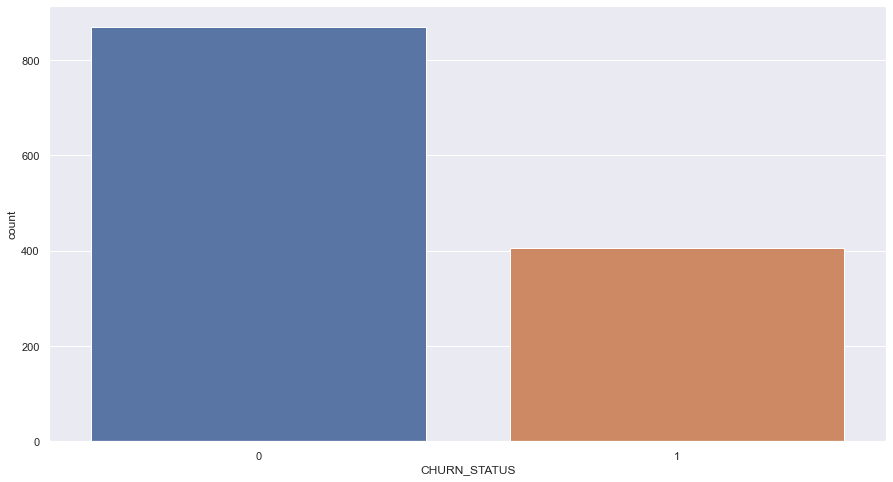

In [236]:
ax = sns.countplot(x="CHURN_STATUS", data=teste_df)

In [237]:
lr = LogisticRegression()

In [238]:
#Separa dados e suas classes

X = teste_df.drop("CHURN_STATUS", axis=1)
y = teste_df.CHURN_STATUS

In [239]:
#Separa os dados entre dados de treino e dados de teste
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, stratify=y, test_size=0.3) 

In [240]:
#treina o algoritmo
lr.fit(X_train, y_train )

LogisticRegression()

In [241]:
#coloca as previsões na variável y_pred
y_pred = lr.predict(X_test)

y_pred_prob = lr.predict_proba(X_test)

In [242]:
from sklearn.metrics import accuracy_score
#checka a acurácia do modelo
accuracy_score(y_test, y_pred)

0.7284595300261096

In [243]:
#Recall e Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.99      0.83       261
           1       0.88      0.17      0.29       122

    accuracy                           0.73       383
   macro avg       0.80      0.58      0.56       383
weighted avg       0.77      0.73      0.66       383



In [244]:
# Confusion Matrix
print (pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Prediction'], margins=True))

Prediction    0   1  All
True                    
0           258   3  261
1           101  21  122
All         359  24  383


In [245]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.5803184473337102

In [246]:
#Instancia o NearMiss
nr = NearMiss()

In [247]:
#Aplica o NearMiss para igual as classes
X, y = nr.fit_resample(X,y)

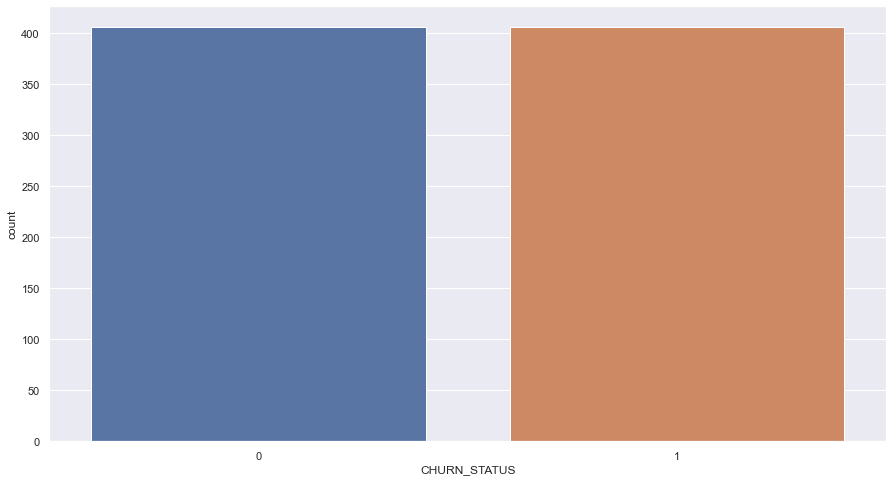

In [248]:
#Checa a quantidade das amostras
ax = sns.countplot(x=y)

In [249]:
lr = LogisticRegression()

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, stratify=y, test_size=0.3) 

In [251]:
lr.fit(X_train, y_train )

LogisticRegression()

In [252]:
y_pred = lr.predict(X_test)

In [253]:
accuracy_score(y_test, y_pred)

0.7786885245901639

In [254]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79       122
           1       0.82      0.71      0.76       122

    accuracy                           0.78       244
   macro avg       0.78      0.78      0.78       244
weighted avg       0.78      0.78      0.78       244



In [255]:
print (pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Prediction'], margins=True))

Prediction    0    1  All
True                     
0           103   19  122
1            35   87  122
All         138  106  244


## Não ficou enviesado em aprender somente uma classe

In [256]:
probabilidade = lr.predict_proba(X)
probabilidade

array([[0.64799097, 0.35200903],
       [0.86299506, 0.13700494],
       [0.84376123, 0.15623877],
       ...,
       [0.70659423, 0.29340577],
       [0.66892003, 0.33107997],
       [0.72590204, 0.27409796]])

In [104]:
calculo = cubo[cubo['CODCOB'].str.contains('BNF|BNFT')]
calculo['TOTAL_VENDA'].sum()

76291.698133

<AxesSubplot:xlabel='CHURN_STATUS', ylabel='LUCRO_LIQUIDO'>

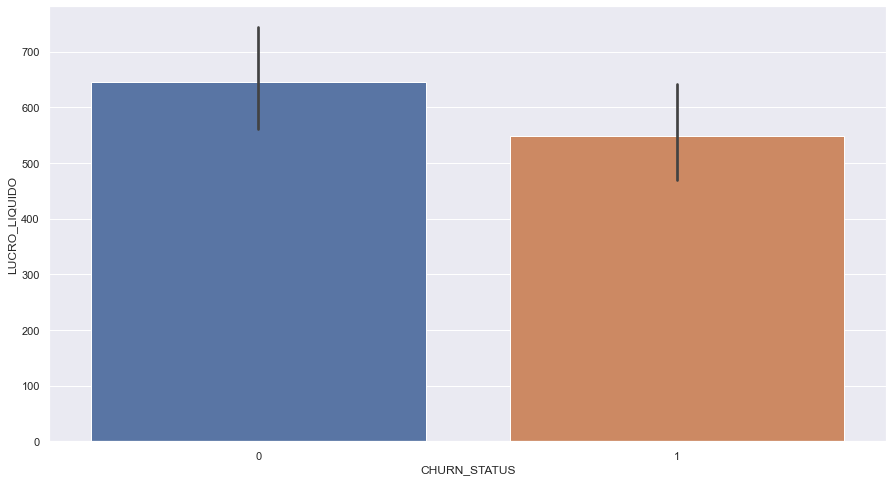

In [105]:
aux1 = cubo_cliente[['CHURN_STATUS', 'LUCRO_LIQUIDO']].groupby('CHURN_STATUS').sum().reset_index()
sns.barplot(x='CHURN_STATUS', y='LUCRO_LIQUIDO', data=cubo_cliente)

In [106]:
X_train

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,LUCRO_LIQUIDO,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,TOP_M,TOP_G,TOP_R,CODCIDADE_16306,CODCIDADE_16308,CODCIDADE_16309,CODCIDADE_16310,CODCIDADE_16312,CODCIDADE_16314,CODCIDADE_16321,CODCIDADE_16322,CODCIDADE_16325,CODCIDADE_16327,CODCIDADE_16330,CODCIDADE_16339,CODCIDADE_16346,CODCIDADE_16349,CODCIDADE_16350,CODCIDADE_16353,CODCIDADE_16358,CODCIDADE_16359,CODCIDADE_16365,CODCIDADE_16368,CODCIDADE_16380,CODCIDADE_16385,CODCIDADE_16388,CODCIDADE_16390,CODCIDADE_16392,CODCIDADE_16394,CODCIDADE_16396,CODCIDADE_16399,CODCIDADE_16403,CODCIDADE_16404,CODCIDADE_16405,CODCIDADE_16408,CODCIDADE_16409,CODCIDADE_16415,CODCIDADE_16416,CODCIDADE_16418,CODCIDADE_16420,CODCIDADE_16423,CODCIDADE_16424,CODCIDADE_16426,CODCIDADE_16435,CODCIDADE_16436,CODCIDADE_16441,CODUSUR_300,CODUSUR_306,CODUSUR_321,CODUSUR_323,CODUSUR_328,CODUSUR_335,CODUSUR_352,CODUSUR_362,CODUSUR_377,CODUSUR_380,CODUSUR_385,CODUSUR_390,CODUSUR_391,CODUSUR_400,CODUSUR_401,CODUSUR_402,CODUSUR_403,CODUSUR_404,CODUSUR_405,CODUSUR_406,CODUSUR_2021,CODUSUR_2022,CODSUPERVISOR_61,CODSUPERVISOR_136,CODSUPERVISOR_138,CODFILIAL_1
268,15151,1,1325.52,1627.38,22.00,0.00,301.87,301.87,0.00,583.38,0.00,0.00,0.19,0.23,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
230,2281,1,2906.53,3564.71,48.00,0.00,658.19,658.19,0.00,0.00,860.60,0.00,0.18,0.23,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
783,14130,1,2692.92,3056.55,51.90,0.00,363.63,363.63,0.00,637.87,0.00,0.00,0.12,0.14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
696,2442,1,3917.88,4806.60,62.00,0.00,888.72,888.72,0.00,0.00,868.39,0.00,0.18,0.23,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
434,18428,1,118.33,159.47,2.00,0.00,41.14,41.14,449.25,0.00,0.00,0.00,0.26,0.35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,18655,1,35.53,47.32,0.53,0.00,11.79,11.79,0.00,265.68,0.00,0.00,0.25,0.33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
132,16888,1,539.76,824.90,10.00,0.00,285.14,285.14,0.00,695.40,0.00,0.00,0.35,0.53,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
563,16274,1,11984.44,15191.30,208.50,0.00,3206.86,3206.86,0.00,0.00,3174.00,0.00,0.21,0.27,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
30,14055,1,434.74,535.60,8.00,0.00,100.86,100.86,0.00,329.40,0.00,0.00,0.19,0.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [107]:
X_test

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,LUCRO_LIQUIDO,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,TOP_M,TOP_G,TOP_R,CODCIDADE_16306,CODCIDADE_16308,CODCIDADE_16309,CODCIDADE_16310,CODCIDADE_16312,CODCIDADE_16314,CODCIDADE_16321,CODCIDADE_16322,CODCIDADE_16325,CODCIDADE_16327,CODCIDADE_16330,CODCIDADE_16339,CODCIDADE_16346,CODCIDADE_16349,CODCIDADE_16350,CODCIDADE_16353,CODCIDADE_16358,CODCIDADE_16359,CODCIDADE_16365,CODCIDADE_16368,CODCIDADE_16380,CODCIDADE_16385,CODCIDADE_16388,CODCIDADE_16390,CODCIDADE_16392,CODCIDADE_16394,CODCIDADE_16396,CODCIDADE_16399,CODCIDADE_16403,CODCIDADE_16404,CODCIDADE_16405,CODCIDADE_16408,CODCIDADE_16409,CODCIDADE_16415,CODCIDADE_16416,CODCIDADE_16418,CODCIDADE_16420,CODCIDADE_16423,CODCIDADE_16424,CODCIDADE_16426,CODCIDADE_16435,CODCIDADE_16436,CODCIDADE_16441,CODUSUR_300,CODUSUR_306,CODUSUR_321,CODUSUR_323,CODUSUR_328,CODUSUR_335,CODUSUR_352,CODUSUR_362,CODUSUR_377,CODUSUR_380,CODUSUR_385,CODUSUR_390,CODUSUR_391,CODUSUR_400,CODUSUR_401,CODUSUR_402,CODUSUR_403,CODUSUR_404,CODUSUR_405,CODUSUR_406,CODUSUR_2021,CODUSUR_2022,CODSUPERVISOR_61,CODSUPERVISOR_136,CODSUPERVISOR_138,CODFILIAL_1
82,13726,1,480.72,568.11,8.85,0.00,87.40,87.40,0.00,500.00,0.00,0.00,0.15,0.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
624,2451,1,2389.08,2983.18,39.78,0.00,594.10,594.10,478.80,0.00,0.00,0.00,0.20,0.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
209,17303,1,480.35,616.32,7.75,0.00,135.97,135.97,0.00,0.00,334.56,0.00,0.22,0.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
38,2872,1,172.04,184.43,2.50,0.00,12.39,12.39,0.00,0.00,285.14,0.00,0.07,0.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
541,15994,1,232.28,296.46,3.62,0.00,64.18,64.18,0.00,391.20,0.00,0.00,0.22,0.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,18419,1,774.60,1039.02,17.03,0.00,264.42,264.42,0.00,486.15,0.00,0.00,0.25,0.34,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
409,4049,1,141.81,200.08,3.27,0.00,58.27,58.27,0.00,0.00,0.00,580.00,0.29,0.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
413,18611,1,426.59,591.31,9.10,0.00,164.72,164.72,0.00,477.00,0.00,0.00,0.28,0.39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
277,16701,1,368.66,491.55,6.67,0.00,122.89,122.89,468.97,0.00,0.00,0.00,0.25,0.33,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1


In [108]:
X_test['BONIFICACAO'].sum()

0.0

In [109]:
Y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,


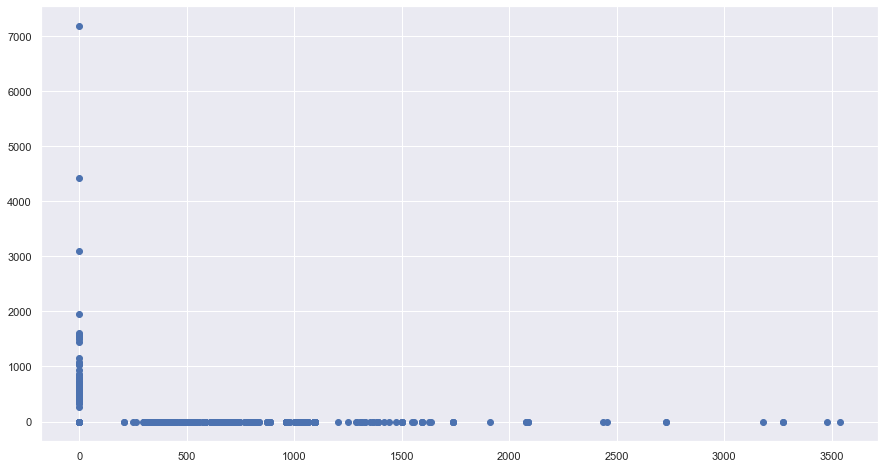

In [110]:
plt.scatter(teste_df['VENDA_G'], teste_df['VENDA_OUTROS'] );

In [111]:
from sklearn.metrics import roc_curve

Text(0, 0.5, 'TOP_G')

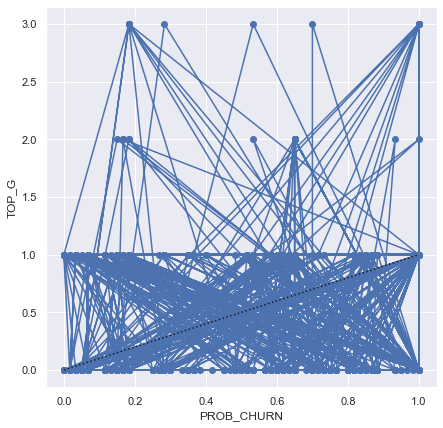

In [112]:
plt.figure(figsize=(7,7))
plt.plot(cubo_cliente['PROB_CHURN'],cubo_cliente['TOP_G'], marker='o')
plt.plot([0,1], [0,1], linestyle=':', color='k')
plt.xlabel('PROB_CHURN')
plt.ylabel('TOP_G')

In [113]:
teste_df

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,LUCRO_LIQUIDO,CHURN_STATUS,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,TOP_M,TOP_G,TOP_R,CODCIDADE_16306,CODCIDADE_16308,CODCIDADE_16309,CODCIDADE_16310,CODCIDADE_16312,CODCIDADE_16314,CODCIDADE_16321,CODCIDADE_16322,CODCIDADE_16325,CODCIDADE_16327,CODCIDADE_16330,CODCIDADE_16339,CODCIDADE_16346,CODCIDADE_16349,CODCIDADE_16350,CODCIDADE_16353,CODCIDADE_16358,CODCIDADE_16359,CODCIDADE_16365,CODCIDADE_16368,CODCIDADE_16380,CODCIDADE_16385,CODCIDADE_16388,CODCIDADE_16390,CODCIDADE_16392,CODCIDADE_16394,CODCIDADE_16396,CODCIDADE_16399,CODCIDADE_16403,CODCIDADE_16404,CODCIDADE_16405,CODCIDADE_16408,CODCIDADE_16409,CODCIDADE_16415,CODCIDADE_16416,CODCIDADE_16418,CODCIDADE_16420,CODCIDADE_16423,CODCIDADE_16424,CODCIDADE_16426,CODCIDADE_16435,CODCIDADE_16436,CODCIDADE_16441,CODUSUR_300,CODUSUR_306,CODUSUR_321,CODUSUR_323,CODUSUR_328,CODUSUR_335,CODUSUR_352,CODUSUR_362,CODUSUR_377,CODUSUR_380,CODUSUR_385,CODUSUR_390,CODUSUR_391,CODUSUR_400,CODUSUR_401,CODUSUR_402,CODUSUR_403,CODUSUR_404,CODUSUR_405,CODUSUR_406,CODUSUR_2021,CODUSUR_2022,CODSUPERVISOR_61,CODSUPERVISOR_136,CODSUPERVISOR_138,CODFILIAL_1
0,16888,1,539.76,824.90,10.00,0.00,285.14,285.14,0,0.00,695.40,0.00,0.00,0.35,0.53,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,16891,1,175.40,262.34,4.00,0.00,86.94,86.94,0,0.00,0.00,398.32,0.00,0.33,0.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,7888,1,166.77,247.05,3.00,0.00,80.28,80.28,0,0.00,442.50,0.00,0.00,0.32,0.48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,3966,1,117.65,173.24,3.00,0.00,55.59,55.59,0,0.00,0.00,386.72,0.00,0.32,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,8106,1,162.64,237.00,2.00,0.00,74.36,74.36,0,0.00,540.00,0.00,0.00,0.31,0.46,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,16805,1,611.95,630.14,70.00,0.00,18.19,18.19,1,0.00,0.00,329.32,0.00,0.03,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1271,2876,1,145.15,148.50,3.00,0.00,3.35,3.35,1,0.00,0.00,360.49,0.00,0.02,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1272,18268,1,2695.40,2700.00,60.00,0.00,4.60,4.60,0,0.00,0.00,796.64,0.00,0.00,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1273,18414,1,29055.00,28645.00,610.00,0.00,-410.00,-410.00,0,0.00,0.00,4409.83,0.00,-0.01,-0.01,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [216]:
teste_cubo_churn = teste_df[teste_df['CHURN_STATUS'] == 1]

teste_cubo_nochurn = teste_df[teste_df['CHURN_STATUS'] == 0]

taxa_atual_churn =  len(teste_cubo_churn) / (len(teste_cubo_nochurn) + len(teste_cubo_churn))
print("A taxa atual de Churn é:", taxa_atual_churn)

A taxa atual de Churn é: 0.3184313725490196


In [115]:
agrupamento_usur = cubo_cliente[['CODUSUR','CHURN_STATUS']].groupby(['CODUSUR']).mean().sort_values(by='CHURN_STATUS', ascending= False).reset_index()
agrupamento_usur = agrupamento_usur.dropna()
agrupamento_usur[agrupamento_usur['CHURN_STATUS'] > 0.26]

,CODUSUR,CHURN_STATUS
0,328,0.89
1,380,0.68
2,352,0.52
3,362,0.49
4,300,0.38
5,321,0.35


In [116]:
cubo_328 = cubo_cliente[cubo_cliente['CODUSUR'] == 328]
print(cubo_328[cubo_328['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum())
print(cubo_328[cubo_328['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum())
print(cubo_328['BONIFICACAO'].sum())
print(cubo_328['CODCLI'].count())
cubo_328

5521.151838
618.90317
0.0
18


,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
211,4026,1,82.94,109.28,1.62,0.00,26.33,2022-02-04,2022-04-29,26.33,1,16418,328,138,1,0.00,0.00,0.00,378.00,0.24,0.32,1.00,0,0,0
243,18435,1,256.00,335.70,3.75,0.00,79.70,2022-02-03,2022-04-29,79.70,1,16418,328,138,1,0.00,0.00,294.00,0.00,0.24,0.31,1.00,0,0,0
393,18554,1,607.23,779.95,9.50,0.00,172.72,2022-02-11,2022-04-29,172.72,1,16418,328,138,1,0.00,401.76,0.00,0.00,0.22,0.28,1.00,0,0,0
505,1857,1,2861.06,3639.63,51.20,0.00,778.57,2022-02-25,2022-04-29,778.57,1,16418,328,138,1,0.00,0.00,822.43,0.00,0.21,0.27,1.00,0,0,1
515,5551,1,1585.09,2015.30,26.45,0.00,430.21,2022-03-15,2022-04-29,430.21,0,16418,328,138,1,0.00,0.00,0.00,424.95,0.21,0.27,0.75,0,0,0
535,13429,1,1549.14,1966.20,26.98,0.00,417.06,2022-02-21,2022-04-29,417.06,1,16418,328,138,1,0.00,0.00,0.00,650.00,0.21,0.27,1.00,0,0,0
589,2534,1,1747.55,2208.87,33.47,0.00,461.32,2022-02-09,2022-04-29,461.32,1,16418,328,138,1,0.00,636.00,0.00,0.00,0.21,0.26,1.00,0,1,0
657,12903,1,1171.62,1473.08,20.19,0.00,301.46,2022-02-14,2022-04-29,301.46,1,16418,328,138,1,0.00,0.00,0.00,399.95,0.20,0.26,1.00,0,0,0
769,17824,1,5289.15,6578.98,107.52,0.00,1289.83,2022-02-07,2022-04-29,1289.83,1,16418,328,138,1,1136.80,0.00,0.00,0.00,0.20,0.24,1.00,1,0,0
844,14209,1,1106.30,1367.16,11.50,0.00,260.86,2022-02-07,2022-04-29,260.86,1,16418,328,138,1,444.48,0.00,0.00,0.00,0.19,0.24,1.00,0,0,0


In [117]:
cubo_380 = cubo_cliente[cubo_cliente['CODUSUR'] == 380]
print(cubo_380[cubo_380['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum())
print(cubo_380[cubo_380['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum())
print(cubo_380['BONIFICACAO'].sum())
print(cubo_380['CODCLI'].count())
cubo_380

29507.984755
11316.066780000001
0.0
73


,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
17,15038,1,265.81,377.29,3.30,0.00,111.48,2022-02-09,2022-04-29,111.48,1,16321,380,136,1,0.00,388.92,0.00,0.00,0.30,0.42,1.00,0,0,0
20,4790,1,922.72,1307.10,20.00,0.00,384.38,2022-03-09,2022-04-29,384.38,0,16321,380,136,1,0.00,0.00,569.40,0.00,0.29,0.42,0.85,0,0,1
53,14883,1,150.09,205.30,1.85,0.00,55.21,2022-02-09,2022-04-29,55.21,1,16321,380,136,1,0.00,412.86,0.00,0.00,0.27,0.37,1.00,0,0,0
87,17001,1,239.40,323.68,3.53,0.00,84.28,2022-02-09,2022-04-29,84.28,1,16321,380,136,1,260.00,0.00,0.00,0.00,0.26,0.35,1.00,0,0,0
95,1854,1,618.69,834.35,7.95,0.00,215.66,2022-02-11,2022-04-29,215.66,1,16321,380,136,1,1621.96,0.00,0.00,0.00,0.26,0.35,1.00,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,17948,1,193.53,221.46,3.90,0.00,27.92,2022-02-03,2022-04-29,27.92,1,16404,380,136,1,0.00,0.00,365.42,0.00,0.13,0.14,1.00,0,0,0
1202,3444,1,192.10,218.47,4.00,0.00,26.36,2022-03-09,2022-04-29,26.36,0,16321,380,136,1,0.00,0.00,522.77,0.00,0.12,0.14,0.85,0,0,1
1223,13304,1,93.23,105.00,2.00,0.00,11.77,2022-02-10,2022-04-29,11.77,1,16321,380,136,1,0.00,309.64,0.00,0.00,0.11,0.13,1.00,0,0,0
1235,4179,1,5301.75,5926.72,89.50,0.00,624.97,2022-02-11,2022-04-29,624.97,1,16321,380,136,1,0.00,0.00,0.00,1552.76,0.11,0.12,1.00,0,0,0


In [118]:
cubo_352 = cubo_cliente[cubo_cliente['CODUSUR'] == 352]
print(cubo_352[cubo_352['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum())
print(cubo_352[cubo_352['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum())
print(cubo_352['BONIFICACAO'].sum())
print(cubo_352['CODCLI'].count())
cubo_352

17771.019964
7683.464622
0.0
61


,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
22,4049,1,141.81,200.08,3.27,0.00,58.27,2022-02-22,2022-04-29,58.27,1,16418,352,138,1,0.00,0.00,0.00,580.00,0.29,0.41,1.00,0,0,0
30,16252,1,1305.61,1819.59,27.37,0.00,513.98,2022-03-11,2022-04-29,513.98,0,16418,352,138,1,0.00,0.00,398.00,0.00,0.28,0.39,0.82,0,0,0
44,7875,1,1157.52,1593.42,19.00,0.00,435.90,2022-03-11,2022-04-29,435.90,0,16418,352,138,1,0.00,0.00,398.00,0.00,0.27,0.38,0.82,0,0,0
65,1906,1,3372.74,4588.07,55.25,0.00,1215.33,2022-02-04,2022-04-29,1215.33,1,16418,352,138,1,0.00,0.00,681.45,0.00,0.26,0.36,1.00,0,0,1
77,14353,1,261.88,354.92,5.00,0.00,93.04,2022-03-10,2022-04-29,93.04,0,16418,352,138,1,0.00,619.50,0.00,0.00,0.26,0.36,0.83,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,14625,1,256.43,290.35,5.00,0.00,33.92,2022-03-10,2022-04-29,33.92,0,16418,352,138,1,0.00,531.00,0.00,0.00,0.12,0.13,0.83,0,1,0
1218,14208,1,312.04,352.57,5.80,0.00,40.53,2022-02-25,2022-04-29,40.53,1,16418,352,138,1,239.40,0.00,0.00,0.00,0.11,0.13,1.00,0,0,0
1222,7923,1,321.35,362.00,7.33,0.00,40.65,2022-03-04,2022-04-29,40.65,0,16418,352,138,1,0.00,0.00,285.00,0.00,0.11,0.13,0.93,0,0,0
1260,1369,1,10804.20,11676.84,203.00,0.00,872.64,2022-02-01,2022-04-29,872.64,1,16418,352,138,1,0.00,0.00,0.00,7182.00,0.07,0.08,1.00,0,0,0


In [119]:
cubo_362 = cubo_cliente[cubo_cliente['CODUSUR'] == 362]
print(cubo_362[cubo_362['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum())
print(cubo_362[cubo_362['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum())
print(cubo_362['BONIFICACAO'].sum())
print(cubo_362['CODCLI'].count())
cubo_362

7963.745354000001
6614.853137
0.0
53


,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
15,18035,1,290.95,414.62,4.78,0.00,123.67,2022-03-25,2022-04-29,123.67,0,16359,362,138,1,0.00,384.00,0.00,0.00,0.30,0.43,0.58,0,0,0
45,14344,1,550.09,757.20,9.37,0.00,207.11,2022-04-27,2022-04-29,207.11,0,16346,362,138,1,0.00,0.00,449.25,0.00,0.27,0.38,0.03,0,0,0
75,17851,1,3247.40,4404.06,54.60,0.00,1156.66,2022-02-18,2022-04-29,1156.66,1,16359,362,138,1,0.00,960.00,0.00,0.00,0.26,0.36,1.00,0,1,0
100,18428,1,118.33,159.47,2.00,0.00,41.14,2022-02-03,2022-04-29,41.14,1,16359,362,138,1,449.25,0.00,0.00,0.00,0.26,0.35,1.00,0,0,0
103,1457,1,175.13,235.92,2.75,0.00,60.79,2022-04-25,2022-04-29,60.79,0,16359,362,138,1,0.00,414.00,0.00,0.00,0.26,0.35,0.07,0,0,0
157,16437,1,266.40,353.88,6.10,0.00,87.48,2022-02-18,2022-04-29,87.48,1,16359,362,138,1,0.00,576.00,0.00,0.00,0.25,0.33,1.00,0,1,0
162,18391,1,210.70,279.78,2.70,0.00,69.08,2022-02-08,2022-04-29,69.08,1,16327,362,138,1,449.25,0.00,0.00,0.00,0.25,0.33,1.00,0,0,0
168,18630,1,765.26,1014.22,15.13,0.00,248.96,2022-04-27,2022-04-29,248.96,0,16346,362,138,1,0.00,0.00,580.08,0.00,0.25,0.33,0.03,0,0,1
201,14386,1,1857.51,2450.48,30.00,0.00,592.97,2022-02-25,2022-04-29,592.97,1,16365,362,138,1,898.50,0.00,0.00,0.00,0.24,0.32,1.00,0,0,0
210,2564,1,117.51,154.82,2.00,0.00,37.31,2022-03-23,2022-04-29,37.31,0,16346,362,138,1,449.25,0.00,0.00,0.00,0.24,0.32,0.62,0,0,0


In [120]:
cubo_300 = cubo_cliente[cubo_cliente['CODUSUR'] == 300]
print(cubo_300[cubo_300['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum())
print(cubo_300[cubo_300['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum())
print(cubo_300['BONIFICACAO'].sum())
print(cubo_300['CODCLI'].count())
cubo_300

26579.37193
49260.593219
0.0
143


,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
10,7901,1,1011.01,1453.97,17.00,0.00,442.97,2022-04-22,2022-04-29,442.97,0,16310,300,138,1,0.00,0.00,509.94,0.00,0.30,0.44,0.12,0,0,1
21,17988,1,92.50,130.76,2.08,0.00,38.27,2022-02-09,2022-04-29,38.27,1,16358,300,138,1,448.02,0.00,0.00,0.00,0.29,0.41,1.00,0,0,0
37,8211,1,214.35,296.60,4.00,0.00,82.25,2022-03-16,2022-04-29,82.25,0,16392,300,138,1,0.00,309.64,0.00,0.00,0.28,0.38,0.73,0,0,0
59,18395,1,2634.80,3593.44,51.17,0.00,958.64,2022-02-25,2022-04-29,958.64,1,16409,300,138,1,0.00,0.00,835.53,0.00,0.27,0.36,1.00,0,0,1
69,18666,1,309.83,421.11,6.47,0.00,111.29,2022-02-08,2022-04-29,111.29,1,16392,300,138,1,0.00,0.00,324.82,0.00,0.26,0.36,1.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,1679,1,99.21,109.12,2.00,0.00,9.91,2022-03-16,2022-04-29,9.91,0,16392,300,138,1,0.00,309.64,0.00,0.00,0.09,0.10,0.73,0,0,0
1253,16727,1,150.22,163.69,3.00,0.00,13.47,2022-03-08,2022-04-29,13.47,0,16435,300,138,1,0.00,0.00,0.00,332.97,0.08,0.09,0.87,0,0,0
1257,4268,1,6615.26,7182.00,270.00,0.00,566.74,2022-03-24,2022-04-29,566.74,0,16308,300,138,1,0.00,0.00,1331.74,0.00,0.08,0.09,0.60,0,0,2
1259,13990,1,2041.94,2208.35,37.75,0.00,166.41,2022-02-15,2022-04-29,166.41,1,16310,300,138,1,1587.90,0.00,0.00,0.00,0.08,0.08,1.00,1,0,0


In [121]:
cubo_321 = cubo_cliente[cubo_cliente['CODUSUR'] == 321]
print(cubo_321[cubo_321['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum())
print(cubo_321[cubo_321['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum())
print(cubo_321['BONIFICACAO'].sum())
print(cubo_321['CODCLI'].count())
cubo_321

72791.36269800001
173382.458633
0.0
394


,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
0,16888,1,539.76,824.90,10.00,0.00,285.14,2022-04-20,2022-04-29,285.14,0,16426,321,136,1,0.00,695.40,0.00,0.00,0.35,0.53,0.15,0,1,0
1,16891,1,175.40,262.34,4.00,0.00,86.94,2022-04-18,2022-04-29,86.94,0,16420,321,136,1,0.00,0.00,398.32,0.00,0.33,0.50,0.18,0,0,0
5,18633,1,291.43,422.77,4.00,0.00,131.34,2022-04-25,2022-04-29,131.34,0,16399,321,136,1,0.00,323.40,0.00,0.00,0.31,0.45,0.07,0,0,0
7,2079,1,326.25,471.40,4.25,0.00,145.15,2022-04-20,2022-04-29,145.15,0,16426,321,136,1,0.00,695.40,0.00,0.00,0.31,0.44,0.15,0,1,0
8,4181,1,76.96,111.00,1.00,0.00,34.04,2022-02-23,2022-04-29,34.04,1,16441,321,136,1,0.00,0.00,371.94,0.00,0.31,0.44,1.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,18377,1,2144.91,2295.00,45.00,0.00,150.09,2022-02-23,2022-04-29,150.09,1,16441,321,136,1,0.00,531.56,0.00,0.00,0.07,0.07,1.00,0,1,0
1266,12251,1,250.13,264.87,5.00,0.00,14.74,2022-04-12,2022-04-29,14.74,0,16415,321,136,1,0.00,0.00,398.32,0.00,0.06,0.06,0.28,0,0,0
1270,16805,1,611.95,630.14,70.00,0.00,18.19,2022-02-26,2022-04-29,18.19,1,16423,321,136,1,0.00,0.00,329.32,0.00,0.03,0.03,1.00,0,0,0
1271,2876,1,145.15,148.50,3.00,0.00,3.35,2022-02-26,2022-04-29,3.35,1,16423,321,136,1,0.00,0.00,360.49,0.00,0.02,0.02,1.00,0,0,0


In [122]:
bnfts = cubo[cubo['CODCOB'].str.contains('BNF|BNFT')]

In [123]:
bnfts['TOTAL_VENDA'].sum()

76291.698133

In [124]:
churn_group_cidade = cubo_cliente[cubo_cliente['CHURN_STATUS'] == 1].groupby(by=cubo_cliente['CODCIDADE']).agg({'CODCLI':'count', 'NUMPED':'count', 'CUSTO_TRANSACAO':'sum', 'TOTAL_VENDA':'sum', 'CAIXAS':'sum','BONIFICACAO':'sum', 'LUCRO_BRUTO':'sum', 'LUCRO_LIQUIDO': 'sum', 'CHURN_STATUS':'count', 'VENDA_M':'sum', 'VENDA_G':'sum', 'VENDA_R':'sum', 'VENDA_OUTROS':'sum', 'MARGEM':'mean', 'ROI':'mean', 'PROB_CHURN':'mean', 'TOP_M':'count', 'TOP_G':'count', 'TOP_R':'count'})
churn_group_cidade = churn_group_cidade.sort_values(by='TOTAL_VENDA', ascending=False).reset_index()

In [125]:
nochurn_group_cidade = cubo_cliente[cubo_cliente['CHURN_STATUS'] == 0].groupby(by=cubo_cliente['CODCIDADE']).agg({'CODCLI':'count', 'NUMPED':'count', 'CUSTO_TRANSACAO':'sum', 'TOTAL_VENDA':'sum', 'CAIXAS':'sum','BONIFICACAO':'sum', 'LUCRO_BRUTO':'sum', 'LUCRO_LIQUIDO': 'sum', 'CHURN_STATUS':'count', 'VENDA_M':'sum', 'VENDA_G':'sum', 'VENDA_R':'sum', 'VENDA_OUTROS':'sum', 'MARGEM':'mean', 'ROI':'mean', 'PROB_CHURN':'mean', 'TOP_M':'count', 'TOP_G':'count', 'TOP_R':'count'})
nochurn_group_cidade = nochurn_group_cidade.sort_values(by='TOTAL_VENDA', ascending=False).reset_index()

In [126]:
nochurn_group_cidade

,CODCIDADE,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,LUCRO_LIQUIDO,CHURN_STATUS,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
0,16339,117,117,469605.26,574224.11,7909.09,0.00,104618.85,104618.85,117,0.00,79623.65,64182.19,387.12,0.20,0.25,0.37,117,117,117
1,16327,46,46,243704.44,307737.14,4251.56,0.00,64032.71,64032.71,46,21104.52,17737.89,26316.22,0.00,0.20,0.25,0.42,46,46,46
2,16418,101,101,181391.94,227607.33,3103.84,0.00,46215.39,46215.39,101,0.00,38003.46,51858.39,4075.02,0.21,0.26,0.47,101,101,101
3,16441,32,32,149990.16,184722.81,2616.19,0.00,34732.65,34732.65,32,0.00,8002.34,29848.92,0.00,0.19,0.24,0.57,32,32,32
4,16390,28,28,136162.57,170871.61,2227.41,0.00,34709.04,34709.04,28,36518.39,4712.07,13180.76,0.00,0.21,0.27,0.55,28,28,28
5,16405,37,37,123726.11,152022.01,1995.20,0.00,28295.90,28295.90,37,0.00,5056.59,31599.96,0.00,0.20,0.25,0.63,37,37,37
6,16426,51,51,90471.41,114332.10,1490.64,0.00,23860.69,23860.69,51,0.00,24507.07,11194.29,0.00,0.21,0.27,0.50,51,51,51
7,16385,31,31,82705.52,103437.42,1363.94,0.00,20731.89,20731.89,31,4125.00,8234.03,15890.34,0.00,0.20,0.26,0.61,31,31,31
8,16330,46,46,82608.89,102952.68,1456.45,0.00,20343.79,20343.79,46,1279.63,9939.23,21272.49,0.00,0.19,0.25,0.31,46,46,46
9,16325,45,45,75659.58,95902.40,1244.75,0.00,20242.82,20242.82,45,4839.30,12674.86,15834.31,0.00,0.21,0.26,0.58,45,45,45


In [127]:
churn_group_cidade

,CODCIDADE,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,LUCRO_LIQUIDO,CHURN_STATUS,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
0,16418,57,57,180342.02,218484.20,2948.39,0.00,38142.17,38142.17,57,8382.80,7605.08,30754.03,14490.44,0.19,0.25,1.00,57,57,57
1,16339,51,51,145406.18,182284.28,2490.78,0.00,36878.10,36878.10,51,0.00,42059.15,10081.06,2357.19,0.20,0.25,1.00,51,51,51
2,16441,69,69,124065.05,154896.37,2120.53,0.00,30831.32,30831.32,69,0.00,23789.97,23768.11,1757.71,0.20,0.25,1.00,69,69,69
3,16321,32,32,68162.53,84899.27,1102.96,0.00,16736.73,16736.73,32,15320.29,3771.08,5721.95,9824.16,0.20,0.26,1.00,32,32,32
4,16327,15,15,62319.16,75459.92,946.94,0.00,13140.76,13140.76,15,6455.69,3372.27,8497.50,2539.10,0.18,0.23,1.00,15,15,15
5,16404,19,19,60091.43,74993.75,978.09,0.00,14902.32,14902.32,19,896.05,1238.58,14416.18,3002.76,0.20,0.26,1.00,19,19,19
6,16308,8,8,44589.45,52900.55,793.25,0.00,8311.10,8311.10,8,2778.82,0.00,6227.91,3881.89,0.19,0.23,1.00,8,8,8
7,16385,10,10,33801.95,42635.19,554.15,0.00,8833.24,8833.24,10,898.50,0.00,9413.73,0.00,0.21,0.26,1.00,10,10,10
8,16312,11,11,28535.55,34925.00,470.00,0.00,6389.44,6389.44,11,1587.90,0.00,2095.19,7982.49,0.20,0.25,1.00,11,11,11
9,16390,10,10,28187.39,34413.98,489.60,0.00,6226.59,6226.59,10,13894.11,4140.00,0.00,0.00,0.20,0.26,1.00,10,10,10


In [128]:
agrupamento_usur = cubo_cliente[['CODUSUR','CHURN_STATUS', 'CODCLI']].groupby(['CODUSUR']).agg({'CHURN_STATUS':'mean', 'CODCLI': 'count'}).sort_values(by='CHURN_STATUS', ascending= False).reset_index()
agrupamento_usur = agrupamento_usur.dropna()
agrupamento_usur = agrupamento_usur[agrupamento_usur['CHURN_STATUS'] > 0.26]

In [129]:
agrupamento_usur

,CODUSUR,CHURN_STATUS,CODCLI
0,328,0.89,18
1,380,0.68,73
2,352,0.52,61
3,362,0.49,53
4,300,0.38,143
5,321,0.35,394


In [130]:
soma_churn = churn_group_cidade['TOTAL_VENDA'].sum() 

In [131]:
soma_nochurn = nochurn_group_cidade['TOTAL_VENDA'].sum() 

In [132]:
soma_churn / soma_nochurn

0.4077388730730239

In [133]:
churn_328 = cubo_328[cubo_328['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum()
churn_380 = cubo_380[cubo_380['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum()
churn_352 = cubo_352[cubo_352['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum()
churn_362 = cubo_362[cubo_362['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum()
churn_300 = cubo_300[cubo_300['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum()
churn_321 = cubo_321[cubo_321['CHURN_STATUS'] == 1]['LUCRO_LIQUIDO'].sum()

In [134]:
nochurn_328 = cubo_328[cubo_328['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum()
nochurn_380 = cubo_380[cubo_380['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum()
nochurn_352 = cubo_352[cubo_352['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum()
nochurn_362 = cubo_362[cubo_362['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum()
nochurn_300 = cubo_300[cubo_300['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum()
nochurn_321 = cubo_321[cubo_321['CHURN_STATUS'] == 0]['LUCRO_LIQUIDO'].sum()

In [135]:
agrupamento_usur = agrupamento_usur.assign(CHURNERS = [churn_328, churn_380, churn_352, churn_362, churn_300, churn_321])

In [136]:
agrupamento_usur = agrupamento_usur.assign(NO_CHURNERS = [nochurn_328, nochurn_380, nochurn_352, nochurn_362, nochurn_300, nochurn_321])

In [137]:
agrupamento_usur['TOTAL'] = agrupamento_usur['CHURNERS'] + agrupamento_usur['NO_CHURNERS']
agrupamento_usur['P_CHURNERS'] = agrupamento_usur['CHURNERS'] / agrupamento_usur['TOTAL']
agrupamento_usur['QT_CHURNERS'] = agrupamento_usur['CHURNERS'] / agrupamento_usur['TOTAL']
agrupamento_usur['P_NOCHURNERS'] = agrupamento_usur['NO_CHURNERS'] / agrupamento_usur['TOTAL']
agrupamento_usur['QT_NOCHURNERS'] = agrupamento_usur['NO_CHURNERS'] / agrupamento_usur['TOTAL']
agrupamento_usur['META'] = agrupamento_usur['CHURNERS'] * 0.26

In [138]:
agrupamento_usur

,CODUSUR,CHURN_STATUS,CODCLI,CHURNERS,NO_CHURNERS,TOTAL,P_CHURNERS,QT_CHURNERS,P_NOCHURNERS,QT_NOCHURNERS,META
0,328,0.89,18,5521.15,618.90,6140.06,0.90,0.90,0.10,0.10,1435.50
1,380,0.68,73,29507.98,11316.07,40824.05,0.72,0.72,0.28,0.28,7672.08
2,352,0.52,61,17771.02,7683.46,25454.48,0.70,0.70,0.30,0.30,4620.47
3,362,0.49,53,7963.75,6614.85,14578.60,0.55,0.55,0.45,0.45,2070.57
4,300,0.38,143,26579.37,49260.59,75839.97,0.35,0.35,0.65,0.65,6910.64
5,321,0.35,394,72791.36,173382.46,246173.82,0.30,0.30,0.70,0.70,18925.75


In [139]:
agrupamento_usur['META'].sum()

41635.00550014

In [140]:
agrupamento_usur['CHURNERS'].sum()

160134.63653900003

In [141]:
agrupamento_usur['NO_CHURNERS'].sum()

248876.339561

# Manipulation

In [208]:
df_bonificados = cubo[cubo['CODCOB'].str.contains('BNF|BNFT')]

In [209]:
df_vendas = cubo[~cubo['CODCOB'].str.contains('BNF|BNFT')]

In [215]:
cubo_cliente

,CODCLI,NUMPED,CUSTO_TRANSACAO,TOTAL_VENDA,CAIXAS,BONIFICACAO,LUCRO_BRUTO,DATA_PEDIDO,DATA_REF,LUCRO_LIQUIDO,CHURN_STATUS,CODCIDADE,CODUSUR,CODSUPERVISOR,CODFILIAL,VENDA_M,VENDA_G,VENDA_R,VENDA_OUTROS,MARGEM,ROI,PROB_CHURN,TOP_M,TOP_G,TOP_R
0,16888,1,539.76,824.90,10.00,0.00,285.14,2022-04-20,2022-04-29,285.14,0,16426,321,136,1,0.00,695.40,0.00,0.00,0.35,0.53,0.15,0,1,0
1,16891,1,175.40,262.34,4.00,0.00,86.94,2022-04-18,2022-04-29,86.94,0,16420,321,136,1,0.00,0.00,398.32,0.00,0.33,0.50,0.18,0,0,0
2,7888,1,166.77,247.05,3.00,0.00,80.28,2022-03-29,2022-04-29,80.28,0,16418,402,61,1,0.00,442.50,0.00,0.00,0.32,0.48,0.52,0,0,0
3,3966,1,117.65,173.24,3.00,0.00,55.59,2022-03-25,2022-04-29,55.59,0,16404,385,138,1,0.00,0.00,386.72,0.00,0.32,0.47,0.58,0,0,0
4,8106,1,162.64,237.00,2.00,0.00,74.36,2022-04-05,2022-04-29,74.36,0,16418,306,138,1,0.00,540.00,0.00,0.00,0.31,0.46,0.40,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,16805,1,611.95,630.14,70.00,0.00,18.19,2022-02-26,2022-04-29,18.19,1,16423,321,136,1,0.00,0.00,329.32,0.00,0.03,0.03,1.00,0,0,0
1271,2876,1,145.15,148.50,3.00,0.00,3.35,2022-02-26,2022-04-29,3.35,1,16423,321,136,1,0.00,0.00,360.49,0.00,0.02,0.02,1.00,0,0,0
1272,18268,1,2695.40,2700.00,60.00,0.00,4.60,2022-04-08,2022-04-29,4.60,0,16385,335,136,1,0.00,0.00,796.64,0.00,0.00,0.00,0.35,0,0,1
1273,18414,1,29055.00,28645.00,610.00,0.00,-410.00,2022-04-18,2022-04-29,-410.00,0,16339,321,136,1,0.00,0.00,4409.83,0.00,-0.01,-0.01,0.18,0,0,3


In [ ]:
df_cliente = cubo[['CODCLI','', 'CODCLI']]

In [214]:
df_cliente = cubo_cliente.copy()

In [ ]:
df_cliente = df_cliente.drop("NUMPED", axis=1) 
df_cliente = df_cliente.drop("DATA_REF", axis=1)
df_cliente

# Modelagem 2.0

In [195]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [196]:
#Separa dados e suas classes

X = teste_df.drop("CHURN_STATUS", axis=1)
y = teste_df.CHURN_STATUS

## Feature Selection